# **Install Dependencies**

In [ ]:
%%capture
!pip install psutil
!pip install GPUtil
!pip install matplotlib
!pip install torch
!pip install transformers
!pip install accelerate
!pip install safetensors
!pip install pytorch_memlab
!pip install huggingface_hub
!pip install -U memory_profiler
!pip install PyPDF2
!pip install reportlab
!pip install prettytable
!pip install fpdf
!pip install onnx
!pip install onnxruntime

In [ ]:
!pip install onnxruntime-gpu

In [ ]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Imprt Libraries**

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import torch
import os
import time
from io import BytesIO
from reportlab.pdfgen import canvas
from PyPDF2 import PdfMerger
from reportlab.lib.pagesizes import letter, landscape
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle
from prettytable import PrettyTable
from fpdf import FPDF
from reportlab.lib.pagesizes import letter, landscape
from reportlab.lib import colors
from reportlab.lib.units import inch
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle
import psutil
import shutil
import transformers
from transformers import AutoConfig, AutoModel
import accelerate
from accelerate import infer_auto_device_map, init_empty_weights
from transformers import AutoConfig, AutoModelForCausalLM, AutoModelForSeq2SeqLM, AutoTokenizer
from torch.profiler import profile, record_function, ProfilerActivity

In [ ]:
!pip install optimum

In [ ]:
from optimum.onnxruntime import ORTModel

In [ ]:
from transformers import AutoConfig

# Load the model configuration
#config = AutoConfig.from_pretrained('cerebras/Cerebras-GPT-13B')
#config = AutoConfig.from_pretrained("databricks/dolly-v2-12b")
#config = AutoConfig.from_pretrained("databricks/dolly-v2-7b")
config = AutoConfig.from_pretrained("google/vit-base-patch16-224")
#, pretrained=True
with init_empty_weights():
# Create an instance of the model without loading the weights
    model = AutoModel.from_config(config)

device_map = infer_auto_device_map(model)
model_modules = []
# Print the layers and their properties
for i, module in enumerate(model.modules()):
    print(f"module {i}: {module}")
    model_modules.append(module)


module 0: ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUA

In [ ]:
!pip install deepspeed

In [ ]:
from deepspeed.profiling.flops_profiler import get_model_profile
from deepspeed.accelerator import get_accelerator

In [ ]:
import torchvision.models as models
import torch
from deepspeed.profiling.flops_profiler import get_model_profile
from deepspeed.accelerator import get_accelerator

with get_accelerator().device():
    #model = models.alexnet()
    batch_size = 256
    flops, macs, params = get_model_profile(model=model, # model
                                    input_shape=(batch_size, 3, 224, 224), # input shape to the model. If specified, the model takes a tensor with this shape as the only positional argument.
                                    args=None, # list of positional arguments to the model.
                                    kwargs=None, # dictionary of keyword arguments to the model.
                                    print_profile=True, # prints the model graph with the measured profile attached to each module
                                    detailed=True, # print the detailed profile
                                    module_depth=-1, # depth into the nested modules, with -1 being the inner most modules
                                    top_modules=1, # the number of top modules to print aggregated profile
                                    warm_up=10, # the number of warm-ups before measuring the time of each module
                                    as_string=True, # print raw numbers (e.g. 1000) or as human-readable strings (e.g. 1k)
                                    output_file="output.txt", # path to the output file. If None, the profiler prints to stdout.
                                    ignore_modules=None) # the list of modules to ignore in the profiling

In [ ]:
from functools import partial
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from deepspeed.profiling.flops_profiler import get_model_profile
from deepspeed.accelerator import get_accelerator


def bert_input_constructor(batch_size, seq_len, tokenizer):
    fake_seq = ""
    for _ in range(seq_len - 2):  # ignore the two special tokens [CLS] and [SEP]
      fake_seq += tokenizer.pad_token
    inputs = tokenizer([fake_seq] * batch_size,
                       padding=True,
                       truncation=True,
                       return_tensors="pt")
    labels = torch.tensor([1] * batch_size)
    inputs = dict(inputs)
    inputs.update({"labels": labels})
    return inputs


with get_accelerator().device(0):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
    batch_size = 4
    seq_len = 128
    enable_profile = True
    if enable_profile:
      flops, macs, params = get_model_profile(
          model,
          kwargs=bert_input_constructor(batch_size, seq_len, tokenizer),
          print_profile=True, # prints the model graph with the measured profile attached to each module                           
          detailed=True, # print the detailed profile
          module_depth=-1, # depth into the nested modules, with -1 being the inner most modules
          top_modules=1, # the number of top modules to print aggregated profile
          warm_up=10, # the number of warm-ups before measuring the time of each module
          as_string=True, # print raw numbers (e.g. 1000) or as human-readable strings (e.g. 1k)
          output_file="output1.txt", # path to the output file. If None, the profiler prints to stdout.
          ignore_modules=None) # the list of modules to ignore in the profiling
          
    else:
      inputs = bert_input_constructor((batch_size, seq_len), tokenizer)
      outputs = model(inputs)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

WIsh

In [ ]:
import torch
import time
import psutil
import numpy as np
from transformers import AutoTokenizer, AutoModelForMaskedLM
#from transformers import ORTModel
import onnx

class ModelProfiler:
    def __init__(self, model_name):
        self.model_name = model_name
        self.tokenizer, self.model, self.model_modules = self._load_model_without_weights(self.model_name)
        self.input_shape = None
        self.cpu_memory_usage = []
        self.cpu_memory_usage_percentage = []
        self.gpu_memory_usage = []
        self.gpu_memory_usage_percentage = []
        self.latency = []
        self.layer_latencies = []
        self.layer_names = [name for name, _ in self.model.named_parameters()]
        self.layer_times = np.zeros(len(self.layer_names))
        self.layer_cpu = np.zeros(len(self.layer_names))
        self.layer_cpu_percentage = np.zeros(len(self.layer_names))
        self.layer_gpu = np.zeros(len(self.layer_names))
        self.layer_gpu_percentage = np.zeros(len(self.layer_names))




   
        # Load the ONNX model using ORTModel
        #self.model = OModel.from_pretrained(model_path)

        # Load the model using the ONNX library
       # self.onnx_model = onnx.load(model_path)


    def _load_onnx_model_without_weights(self, model_name):
        # Load the model configuration
        config = AutoConfig.from_pretrained(self.model_name, low_cpu_mem_usage=True)

        with init_empty_weights():
            onnx_tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            # Create an instance of the model without loading the weights
            onnx_model = ORTModel.from_config(config)

        device_map = infer_auto_device_map(model)

        #onnx_model = onnx.load(model_path)

        onnx_layers = []
        for node in self.onnx_model.graph.node:
            print(node)
            onnx_layers.append(node.op_type)

        # Get all the modules in the model
        onnx_model_modules = []
        for initializer in self.onnx_model.graph.initializer:
            print(initializer)
            onnx_model_modules.append(initializer.name)

        return onnx_tokenizer, onnx_model, onnx_layers, onnx_model_modules




    def _load_model_without_weights(self, model_name):
        # Load the model configuration
        config = AutoConfig.from_pretrained(self.model_name, low_cpu_mem_usage=True)

        with init_empty_weights():
            tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            # Create an instance of the model without loading the weights
            model = AutoModel.from_config(config)

        device_map = infer_auto_device_map(model)
        model_modules = []
        # Print the layers and their properties
        for i, module in enumerate(model.modules()):
            #print(f"module {i}: {module}")
            model_modules.append(module)

        #model_modules = model.modules()

        return tokenizer, model, model_modules

    def _load_model_with_weights(self, model_name):
        # Load the model configuration
        #config = AutoConfig.from_pretrained(model_name)
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        # Create an instance of the model without loading the weights
        model = AutoModel.from_pretrained(model_name)

        #device_map = infer_auto_device_map(model)
        model_modules = []
        # Print the layers and their properties
        for i, module in enumerate(model.modules()):
            #print(f"module {i}: {module}")
            model_modules.append(module)

        #model_modules = model.modules()

        return tokenizer, model, model_modules

    def model_size(self):
        model_size = sum(t.numel() for t in self.model.parameters())
        print(f"Model size: {model_size/1000**2:.1f}M parameters")
        return model_size

    def get_model_modules(self):
        tokenizer, model, model_modules = self._load_model_without_weights(self.model_name)
        print(self.model_name)
        print("--"*10)
        for i, module in enumerate(model_modules):
            print(f"module {i}: {module}")
            #model_modules.append(module)
        print("--"*10)
        return model_modules

    def check_gpu(self):
        try:
            if torch.cuda.is_available():
                return True
            else:
                return False
        except ImportError:
            return False


    def get_CPU_memory_usage_mb(self):
        process = psutil.Process()
        memory_info = process.memory_info()
        cpu_memory_usage = memory_info.rss / (1024 * 1024)
        return cpu_memory_usage



    def get_CPU_memory_usage_percentage(self):
        process = psutil.Process()
        cpu_memory_usage_percentage = process.memory_percent()
        return cpu_memory_usage_percentage



    def get_GPU_memory_usage_mb(self):
        torch.cuda.empty_cache()
        return torch.cuda.max_memory_allocated() / 1024 / 1024

    


    def get_GPU_memory_usage_percentage(self):
        torch.cuda.empty_cache()
        gpu_memory_allocated = torch.cuda.memory_allocated()
        gpu_memory_total = torch.cuda.get_device_properties(0).total_memory
        gpu_memory_usage_percentage = gpu_memory_allocated / gpu_memory_total * 100
        return gpu_memory_usage_percentage


    def profile(self, batch_size, sequence_length):
        # Move input tensor to the same device as the model
        device = next(self.model.parameters()).device
        self.model = self.model.to(device)

        input_tensor = torch.rand(batch_size, sequence_length).long()

        input_tensor = input_tensor.to(device)

        self.input_shape = input_tensor.shape

        # Run forward pass once to warm up CUDA and allocate memory
        with torch.no_grad():
            self.model(input_tensor)
        
        print("--"*30)
        print(f"Model: {self.model_name}")
        print("--"*30)

        with torch.autograd.profiler.profile(use_cuda=True) as prof:
            # Start the process
            output = self.model(input_tensor)
        print(prof)

        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory = True ,record_shapes=True,use_cuda=True,) as prof:
            with record_function("model_inference"):
                  output = self.model(input_tensor)
        print(prof.key_averages(group_by_input_shape=True).table(sort_by="self_cpu_memory_usage"))



    def flop_prof(self, batch_size, sequence_length):
        # Move input tensor to the same device as the model
        device = next(self.model.parameters()).device
        self.model = self.model.to(device)
        

        input_tensor = torch.rand(batch_size, sequence_length).long()

        input_tensor = input_tensor.to(device)

        self.input_shape = input_tensor.shape
        with get_accelerator().device(0):
            flops, macs, params = get_model_profile(model=self.model, # model
                                            input_shape=(batch_size, 3, 224, 224), # input shape to the model. If specified, the model takes a tensor with this shape as the only positional argument.
                                            args=None, # list of positional arguments to the model.
                                            kwargs=None, # dictionary of keyword arguments to the model.
                                            print_profile=True, # prints the model graph with the measured profile attached to each module
                                            detailed=True, # print the detailed profile
                                            module_depth=-1, # depth into the nested modules, with -1 being the inner most modules
                                            top_modules=1, # the number of top modules to print aggregated profile
                                            warm_up=10, # the number of warm-ups before measuring the time of each module
                                            as_string=True, # print raw numbers (e.g. 1000) or as human-readable strings (e.g. 1k)
                                            output_file=None, # path to the output file. If None, the profiler prints to stdout.
                                            ignore_modules=None) # the list of modules to ignore in the profiling
        print(f"FLOPS: {flops}")
        

    def bert_input_constructor(self, batch_size, sequence_length):
        fake_seq = ""
        for _ in range(sequence_length - 2):  # ignore the two special tokens [CLS] and [SEP]
            fake_seq += self.tokenizer.pad_token
            inputs = self.tokenizer([fake_seq] * batch_size,
                            padding=True,
                            truncation=True,
                            return_tensors="pt")
            labels = torch.tensor([1] * batch_size)
            inputs = dict(inputs)
            inputs.update({"labels": labels})
        return inputs



    def compute_flops(self, batch_size, sequence_length):
        # Move input tensor to the same device as the model
        device = next(self.model.parameters()).device
        self.model = self.model.to(device)
        

        input_tensor = torch.rand(batch_size, sequence_length).long()

        input_tensor = input_tensor.to(device)

        self.input_shape = input_tensor.shape
        with get_accelerator().device(0):
            enable_profile = True
            if enable_profile:
              flops, macs, params = get_model_profile(
                  self.model,
                  kwargs=self.bert_input_constructor(batch_size, sequence_length, self.tokenizer),
                  print_profile=True,
                  detailed=True,
              )
            else:
              inputs = self.bert_input_constructor((batch_size, sequence_length), self.tokenizer)
              outputs = self.model(inputs)
        print(f"FLOPS: {flops}")
            





    def profile_layer_by_layer(self, batch_size, sequence_length):
        # Move input tensor to the same device as the model
        device = next(self.model.parameters()).device
        self.model = self.model.to(device)

        input_tensor = torch.rand(batch_size, sequence_length).long()

        input_tensor = input_tensor.to(device)

        self.input_shape = input_tensor.shape

        # Run forward pass once to warm up CUDA and allocate memory
        with torch.no_grad():
            self.model(input_tensor)
        
        print("--"*30)
        print(f"Model: {self.model_name}")
        print("--"*30)

         # Loop through each layer and record timing information
        for i, (name, param) in enumerate(self.model.named_parameters()):
            if param.requires_grad:
                layer = name.split('.')[0]

                    # Start the timer
                start_time = time.time()

                # Run the model forward pass
                with torch.no_grad():
                    self.model(input_tensor)

                # Record the latency
                end_time = time.time()
                latency = end_time - start_time
                self.latency.append(latency)

                # Record CPU and GPU memory usage
                self.layer_cpu[i] = self.get_CPU_memory_usage_mb()
                #self.layer_cpu.append(self.layer_cpu[i])

                self.layer_cpu_percentage[i] = self.get_CPU_memory_usage_percentage()
                #self.layer_cpu_percentage.append(self.layer_cpu_percentage[i])



                if torch.cuda.is_available():
                    self.layer_gpu[i] = self.get_GPU_memory_usage_mb()
                    #self.layer_gpu.append(self.layer_gpu[i])

                    self.layer_gpu_percentage[i] = self.get_GPU_memory_usage_percentage()
                    #self.layer_gpu_percentage.append(self.layer_gpu_percentage)

                else:
                    self.layer_gpu[i] = 0
                    #self.layer_gpu.append(self.layer_gpu[i])

                    self.layer_gpu_percentage[i] = 0
                    #self.layer_gpu_percentage.append(self.layer_gpu_percentage)
                    
               




    def benchmark(self, num_runs, batch_size, sequence_length):
        # Move input tensor to the same device as the model
        device = next(self.model.parameters()).device
        self.model = self.model.to(device)

        input_tensor = torch.rand(batch_size, sequence_length).long()

        input_tensor = input_tensor.to(device)

        self.input_shape = input_tensor.shape

        # Run forward pass once to warm up CUDA and allocate memory
        with torch.no_grad():
            self.model(input_tensor)

            # Start the timer
            start_time = time.time()

            # Run the model forward pass
            with torch.no_grad():
                self.model(input_tensor)

            # Record the latency
            end_time = time.time()
            latency = end_time - start_time
            self.latency.append(latency)

            # Record CPU and GPU memory usage
            cpu_memory_usage = self.get_CPU_memory_usage_mb()
            self.cpu_memory_usage.append(cpu_memory_usage)

            cpu_memory_usage_percentage = self.get_CPU_memory_usage_percentage()
            self.cpu_memory_usage_percentage.append(cpu_memory_usage_percentage)



            if torch.cuda.is_available():
                gpu_memory_usage = self.get_GPU_memory_usage_mb()
                self.gpu_memory_usage.append(gpu_memory_usage)

                gpu_memory_usage_percentage = self.get_GPU_memory_usage_percentage()
                self.gpu_memory_usage_percentage.append(gpu_memory_usage_percentage)

    def print_summary(self):
        print("--"*30)
        print(f"Model: {self.model_name}")
        print("--"*30)
        print(f"Input shape: {self.input_shape}")
        print(f"Number of runs: {len(self.latency)}")
        print(f"Average latency: {np.mean(self.latency):.4f} s")
        print(f"Standard deviation of latency: {np.std(self.latency):.4f} s")
        print(f"Average CPU memory usage: {np.mean(self.cpu_memory_usage):.4f} MB")
        print(f"Average CPU memory usage percentage: {np.mean(self.cpu_memory_usage_percentage):.4f} %")
        print(f"Average GPU memory usage: {np.mean(self.gpu_memory_usage):.4f} MB")
        print(f"Average GPU memory usage percentage: {np.mean(self.gpu_memory_usage_percentage):.4f} %")
        


    
    def plot(self):
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot timing information
        ax1.set_title("profiling_results - " + self.model_name)
        ax1.set_xlabel('Layer Index')
        ax1.set_ylabel('Time (ms)')
        ax1.plot(self.layer_times, 'b', label='Time')
        ax1.tick_params(axis='y', labelcolor='b')

        # Plot CPU and GPU memory usage information
        ax2 = ax1.twinx()
        ax2.set_ylabel('Memory Usage (MB)')
        ax2.plot(self.layer_cpu, 'g', label='CPU')
        ax2.plot(self.layer_gpu, 'r', label='GPU')
        ax2.tick_params(axis='y', labelcolor='g')

        # Add legend and display plot
        fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
        plt.grid()
        plt.show()

    def display_profiling_results(self):
        # Create a table to display the profiling results
        table = PrettyTable()
        table.field_names = ["Layer", "Total time (ms)", "CPU usage (MB)", "CPU usage (%)", "GPU usage (MB)", "GPU usage (%)"]
                           # ,"Memory usage (MB)", "CPU usage (MB)", "GPU usage (MB)" , "Disk usage (MB)"]
        for i, layer_name in enumerate(self.layer_names):
            table.add_row([layer_name, f"{self.layer_times[i]:.2f}", f"{self.layer_cpu[i]:.2f}" , f"{self.layer_cpu_percentage[i]:.2f}", f"{self.layer_gpu[i]:.2f}",  f"{self.layer_gpu_percentage[i]:.2f}"])
           # ,f"{self.mem[i]:.2f}", f"{self.cpu[i]:.2f}",f"{self.gpu[i]:.2f}",f"{self.disk[i]:.2f}"])

        # Print the table to the console
        print(table)


    def save_results_pdf(self):
        filename = "profiling_results - "+self.model_name+".pdf"
        # Create a list of lists to store the profiling results
        data = [["Layer", "Total time (ms)", "CPU usage (MB)", "CPU usage (%)", "GPU usage (MB)", "GPU usage (%)"]]
        for i, layer_name in enumerate(self.layer_names):
            data.append([layer_name, f"{self.layer_times[i]:.2f}", f"{self.layer_cpu[i]:.2f}", f"{self.layer_cpu_percentage[i]:.2f}", f"{self.layer_gpu[i]:.2f}",  f"{self.layer_gpu_percentage[i]:.2f}"])

        # Set up the reportlab PDF document
        doc = SimpleDocTemplate(filename, pagesize=landscape(letter))
        elements = []

        # Create the table and style
        table = Table(data, colWidths=[3.8*inch, 1.4*inch, 1.4*inch, 1.4*inch, 1.4*inch, 1.4*inch, 1.4*inch])
        table.setStyle(TableStyle([
            ("BACKGROUND", (0, 0), (-1, 0), colors.gray),
            ("TEXTCOLOR", (0, 0), (-1, 0), colors.whitesmoke),
            ("ALIGN", (0, 0), (-1, 0), "CENTER"),
            ("FONTNAME", (0, 0), (-1, 0), "Helvetica"),
            ("FONTSIZE", (0, 0), (-1, 0), 14),
            ("BOTTOMPADDING", (0, 0), (-1, 0), 12),
            ("BACKGROUND", (0, 1), (-1, -1), colors.beige),
            ("TEXTCOLOR", (0, 1), (-1, -1), colors.black),
            ("ALIGN", (0, 1), (-1, -1), "CENTER"),
            ("FONTNAME", (0, 1), (-1, -1), "Helvetica"),
            ("FONTSIZE", (0, 1), (-1, -1), 12),
            ("BOTTOMPADDING", (0, 1), (-1, -1), 6),
            ("GRID", (0, 0), (-1, -1), 1, colors.black),
        ]))

        # Add the table to the elements list and write to the PDF
        elements.append(table)
        doc.build(elements)

        print(f"Results saved to {os.path.abspath(filename)}")




In [ ]:
import time
from transformers import AutoTokenizer, AutoModelForMaskedLM
#from model_profiler import ModelProfiler

# Define a list of pre-trained models to test
models = [
    "cerebras/Cerebras-GPT-13B",
    "bert-base-uncased",
    "bert-large-uncased",
    "gpt2",
    "gpt2-medium",
    "gpt2-large",
    "distilgpt2",
    "roberta-base",
    "roberta-large",
    "albert-base-v2",
    "albert-large-v2"
]

# Define your input tensor here
batch_size = 8
sequence_length = 128
#input_tensor = torch.rand(batch_size, sequence_length).long()

# Run the benchmarks for each model
for model_name in models:
    profiler = ModelProfiler(model_name)
    profiler.profile(batch_size = batch_size, sequence_length=sequence_length)
    #profiler.profile_layer_by_layer(batch_size = batch_size, sequence_length=sequence_length)
    profiler.benchmark(num_runs=10, batch_size = batch_size, sequence_length=sequence_length)
    #profiler.display_profiling_results()
    profiler.print_summary()
    #profiler.get_model_modules()
    print("")
    time.sleep(2)


In [ ]:
model_name = "microsoft/resnet-18"

# Define your input tensor here
batch_size = 8
sequence_length = 128
#input_tensor = torch.rand(batch_size, sequence_length).long()


In [ ]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

profiler = ModelProfiler(model_name)

In [ ]:
profiler.profile(batch_size = batch_size, sequence_length=sequence_length)

In [ ]:
profiler.flop_prof(batch_size = batch_size, sequence_length=sequence_length)

In [ ]:


profiler.profile_layer_by_layer(batch_size = batch_size, sequence_length=sequence_length)
profiler.display_profiling_results()

profiler.benchmark(num_runs=10, batch_size = batch_size, sequence_length=sequence_length)
profiler.print_summary()

In [ ]:
profiler.profile(batch_size, sequence_length)

------------------------------------------------------------
Model: bert-base-uncased
------------------------------------------------------------
---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                       Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 aten::ones         0.00%      58.000us         0.00%      94.000us      94.000us      49.000us         0.00%     102.000us     102.000us             1  
                aten::empty         0.00%      28.000us         0.00%      28.000us      28.000us      39.000us         0.00%      39.000us      39.000us             1  
  

/usr/local/lib/python3.9/dist-packages/torch/profiler/profiler.py:433: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")


---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ----------------------------------------------  
                       Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                                    Input Shapes  
---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ----------------------------------------------  
                aten::empty         0.07%       1.535ms         0.07%       1.535ms      11.992us     219.20 Mb     219.20 Mb           128                        [[], [], [], [], [], []]  
                aten::addmm        23.52%     549.454ms        25.10%     586.509ms      12.219ms     144.00 Mb     144.00 Mb            48        [[768], [1024, 768], [768, 768], [], []]  
                aten::addmm        22.29%     520.

In [ ]:
profiler.benchmark(num_runs=10, batch_size = batch_size, sequence_length=sequence_length)
profiler.print_summary()

------------------------------------------------------------
Model: bert-base-uncased
------------------------------------------------------------
Input shape: torch.Size([8, 128])
Number of runs: 201
Average latency: 2.8899 s
Standard deviation of latency: 0.5775 s
Average CPU memory usage: 1438.8848 MB
Average CPU memory usage percentage: 11.0807 %
Average GPU memory usage: 0.0000 MB
Average GPU memory usage percentage: 0.0000 %


2

In [ ]:

#nice

class Profiler:
    def __init__(self, model_name):
        self.model_name = model_name
        self.tokenizer, self.model, self.model_modules = self._load_model_without_weights(self.model_name)
        self.layer_names = [name for name, _ in self.model.named_parameters()]
        self.layer_times = np.zeros(len(self.layer_names))
        self.layer_cpu = np.zeros(len(self.layer_names))
        self.layer_cpu_percentage = np.zeros(len(self.layer_names))
        self.layer_gpu = np.zeros(len(self.layer_names))
        self.layer_gpu_percentage = np.zeros(len(self.layer_names))
        self.input_shape = None
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        


    def _load_model_without_weights(self, model_name):
        # Load the model configuration
        config = AutoConfig.from_pretrained(model_name, low_cpu_mem_usage=True)

        with init_empty_weights():
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            # Create an instance of the model without loading the weights
            model = AutoModel.from_config(config)

        device_map = infer_auto_device_map(model)
        model_modules = []
        # Print the layers and their properties
        for i, module in enumerate(model.modules()):
            #print(f"module {i}: {module}")
            model_modules.append(module)

        #model_modules = model.modules()

        return tokenizer, model, model_modules

    def model_size(self):
        model_size = sum(t.numel() for t in self.model.parameters())
        print(f"Model size: {model_size/1000**2:.1f}M parameters")
        return model_size

    def check_gpu(self):
        try:
            if torch.cuda.is_available():
                return True
            else:
                return False
        except ImportError:
            return False

    def calculate_elapsed_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        #elapsed_time_ms = elapsed_time.total_seconds()
        return elapsed_time


    def get_cpu_memory_usage_mb(self):
        """Return CPU memory usage in MB."""
        process = psutil.Process()
        memory_info = process.memory_info()
        cpu_memory_usage = memory_info.rss / (1024 * 1024)
        return cpu_memory_usage

    def calculate_gpu_usage(self):
        if torch.cuda.is_available():
            # Get the current device
            device = torch.cuda.current_device()

            # Calculate the memory usage
            allocated =torch.cuda.max_memory_allocated() / (1024 * 1024)

        else:
            allocated = 0
        return allocated


    def perc_calculate_gpu_usage(self):
        if torch.cuda.is_available():
            # Get the current device
            device = torch.cuda.current_device()

            # Calculate the memory usage
            allocated = torch.cuda.memory_allocated(device)
            cached = torch.cuda.memory_reserved(device) - allocated
            utilization = allocated / (allocated + cached)

            # Calculate the GPU usage percentage
            gpu_usage_percentage = round(utilization * 100, 2)
        else:
            gpu_usage_percentage = 0.0

        return gpu_usage_percentage



    def calculate_gpu_usage_percentage(self):
        if torch.cuda.is_available():
            total_mem = torch.cuda.get_device_properties(0).total_memory
            allocated_mem = torch.cuda.memory_allocated()
            gpu_percentage = allocated_mem / total_mem * 100
            return gpu_percentage
        else:
            return 0


   

    def profile(self, input_tensor):
        # Move input tensor to the same device as the model
        device = next(self.model.parameters()).device
        input_tensor = input_tensor.to(device)

        self.input_shape = input_tensor.shape

        # Run forward pass once to warm up CUDA and allocate memory
        with torch.no_grad():
            self.model(input_tensor)

        # Loop through each layer and record timing information
        for i, (name, param) in enumerate(self.model.named_parameters()):
            if param.requires_grad:
                layer = name.split('.')[0]
                
                start_time = torch.cuda.Event(enable_timing=True)
                end_time = torch.cuda.Event(enable_timing=True)
                start_time.record()
                # Start the process
                output = self.model(input_tensor)
                end_time.record()
                torch.cuda.synchronize()
                elapsed_time = start_time.elapsed_time(end_time)
                self.layer_times[i] = elapsed_time
                """
                start_time = time.time()
                #with torch.autograd.profiler.profile(enabled=True, use_cuda=self.check_gpu()) as prof:
                output = self.model(input_tensor)
                end_time = time.time()
                """
                #elapsed_time = self.calculate_elapsed_time(start_time, end_time)

                self.layer_cpu[i] = self.get_cpu_memory_usage_mb()
                self.layer_cpu_percentage[i] = elapsed_time / 1000 # convert to ms
                
                if torch.cuda.is_available():
                    #self.layer_gpu[i] = torch.cuda.max_memory_allocated() / (1024 * 1024)
                    self.layer_gpu[i] = self.calculate_gpu_usage() 
                    self.layer_gpu_percentage[i]=self.calculate_gpu_usage_percentage()
                else:
                    self.layer_gpu[i]=0
                    self.layer_gpu_percentage[i]=0 



                    """
                    if torch.cuda.max_memory_reserved() == 0:
                        self.layer_gpu_percentage[i] = 0
                    else:
                        gpu_percentage = torch.cuda.max_memory_allocated() / torch.cuda.max_memory_reserved() * 100
                        self.layer_gpu_percentage[i] = self.layer_gpu[i] / gpu_percentage
                else:
                    self.layer_gpu[i]=0
                    self.layer_gpu_percentage[i]=0
                  """

    def visualize_profile_results(self, layer_times, layer_cpu, layer_gpu):
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.scatter(range(len(layer_times)), layer_times, s=2, label='Execution time')
        ax.scatter(range(len(layer_cpu)), layer_cpu, s=2, label='CPU memory')
        ax.scatter(range(len(layer_gpu)), layer_gpu, s=2, label='GPU memory')
        ax.set_xlabel('Layer index')
        ax.set_ylabel('Memory usage (MB) / Execution time (ms)')
        ax.set_title('Profiling Results')
        ax.legend()
        plt.show()

    
    def plot(self):
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot timing information
        ax1.set_title("profiling_results - " + self.model_name)
        ax1.set_xlabel('Layer Index')
        ax1.set_ylabel('Time (ms)')
        ax1.plot(self.layer_times, 'b', label='Time')
        ax1.tick_params(axis='y', labelcolor='b')

        # Plot CPU and GPU memory usage information
        ax2 = ax1.twinx()
        ax2.set_ylabel('Memory Usage (MB)')
        ax2.plot(self.layer_cpu, 'g', label='CPU')
        ax2.plot(self.layer_gpu, 'r', label='GPU')
        ax2.tick_params(axis='y', labelcolor='g')

        # Add legend and display plot
        fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
        plt.grid()
        plt.show()

    def display_profiling_results(self):
        # Create a table to display the profiling results
        table = PrettyTable()
        table.field_names = ["Layer", "Total time (ms)", "CPU usage (MB)", "CPU usage (%)", "GPU usage (MB)", "GPU usage (%)"]
                           # ,"Memory usage (MB)", "CPU usage (MB)", "GPU usage (MB)" , "Disk usage (MB)"]
        for i, layer_name in enumerate(self.layer_names):
            table.add_row([layer_name, f"{self.layer_times[i]:.2f}", f"{self.layer_cpu[i]:.2f}" , f"{self.layer_cpu_percentage[i]:.2f}", f"{self.layer_gpu[i]:.2f}",  f"{self.layer_gpu_percentage[i]:.2f}"])
           # ,f"{self.mem[i]:.2f}", f"{self.cpu[i]:.2f}",f"{self.gpu[i]:.2f}",f"{self.disk[i]:.2f}"])

        # Print the table to the console
        print(table)


    def save_results_pdf(self):
        filename = "profiling_results - "+self.model_name+".pdf"
        # Create a list of lists to store the profiling results
        data = [["Layer", "Total time (ms)", "CPU usage (MB)", "CPU usage (%)", "GPU usage (MB)", "GPU usage (%)"]]
        for i, layer_name in enumerate(self.layer_names):
            data.append([layer_name, f"{self.layer_times[i]:.2f}", f"{self.layer_cpu[i]:.2f}", f"{self.layer_cpu_percentage[i]:.2f}", f"{self.layer_gpu[i]:.2f}",  f"{self.layer_gpu_percentage[i]:.2f}"])

        # Set up the reportlab PDF document
        doc = SimpleDocTemplate(filename, pagesize=landscape(letter))
        elements = []

        # Create the table and style
        table = Table(data, colWidths=[3.8*inch, 1.4*inch, 1.4*inch, 1.4*inch, 1.4*inch, 1.4*inch, 1.4*inch])
        table.setStyle(TableStyle([
            ("BACKGROUND", (0, 0), (-1, 0), colors.gray),
            ("TEXTCOLOR", (0, 0), (-1, 0), colors.whitesmoke),
            ("ALIGN", (0, 0), (-1, 0), "CENTER"),
            ("FONTNAME", (0, 0), (-1, 0), "Helvetica"),
            ("FONTSIZE", (0, 0), (-1, 0), 14),
            ("BOTTOMPADDING", (0, 0), (-1, 0), 12),
            ("BACKGROUND", (0, 1), (-1, -1), colors.beige),
            ("TEXTCOLOR", (0, 1), (-1, -1), colors.black),
            ("ALIGN", (0, 1), (-1, -1), "CENTER"),
            ("FONTNAME", (0, 1), (-1, -1), "Helvetica"),
            ("FONTSIZE", (0, 1), (-1, -1), 12),
            ("BOTTOMPADDING", (0, 1), (-1, -1), 6),
            ("GRID", (0, 0), (-1, -1), 1, colors.black),
        ]))

        # Add the table to the elements list and write to the PDF
        elements.append(table)
        doc.build(elements)

        print(f"Results saved to {os.path.abspath(filename)}")


In [ ]:
#model_name = "bert-base-uncased"
#model_name = "optimum/gpt2"
#model_name = "bert-base-uncased"
#model_name = "xlm-roberta-large"
#model_name = "facebook/bart-large"
#model_name = "cerebras/Cerebras-GPT-13B"
model_name = "facebook/opt-6.7b"

# Initialize the profiler
profiler = Profiler(model_name)

model= profiler.model
model_modules = profiler.model_modules
# Define your input tensor here
batch_size = 8
sequence_length = 128
input_tensor = torch.rand(batch_size, sequence_length).long()


# Run the profiler
profiler.profile(input_tensor)

# Print the profiling results to the console and save to a PDF file
#filename = "profiling_results1.pdf"
#profiler.save_results_pdf()

In [ ]:
profiler.display_profiling_results()

+-----------------------------------------------+-----------------+----------------+---------------+----------------+---------------+
|                     Layer                     | Total time (ms) | CPU usage (MB) | CPU usage (%) | GPU usage (MB) | GPU usage (%) |
+-----------------------------------------------+-----------------+----------------+---------------+----------------+---------------+
|          decoder.embed_tokens.weight          |      209.56     |    4571.57     |      0.21     |      0.00      |      0.00     |
|         decoder.embed_positions.weight        |      214.87     |    4571.57     |      0.21     |      0.00      |      0.00     |
|        decoder.final_layer_norm.weight        |      214.07     |    4571.57     |      0.21     |      0.00      |      0.00     |
|         decoder.final_layer_norm.bias         |      213.29     |    4571.57     |      0.21     |      0.00      |      0.00     |
|    decoder.layers.0.self_attn.k_proj.weight   |      214.32 

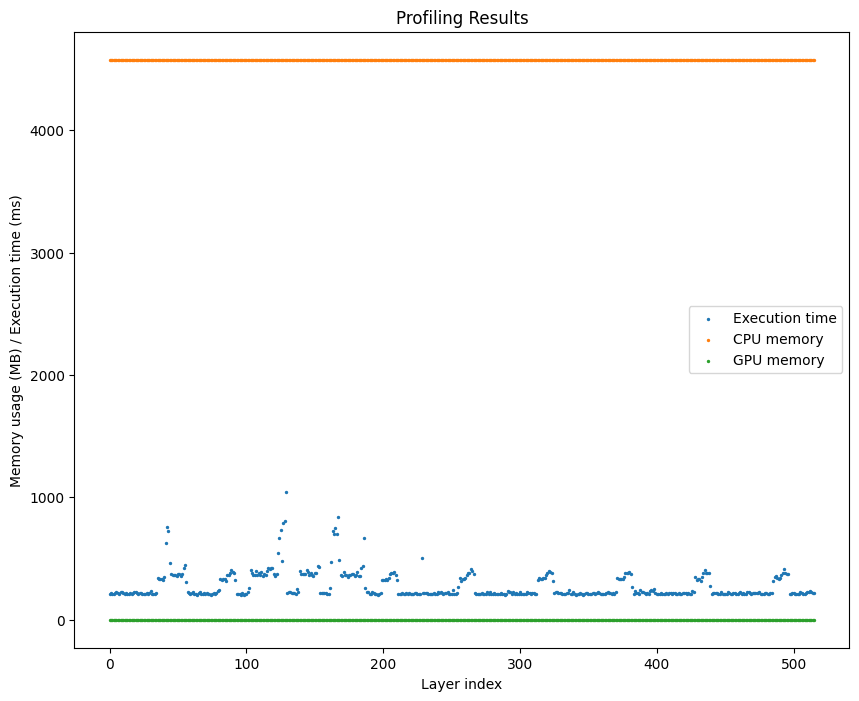

In [ ]:
profiler.visualize_profile_results(profiler.layer_times, profiler.layer_cpu, profiler.layer_gpu)


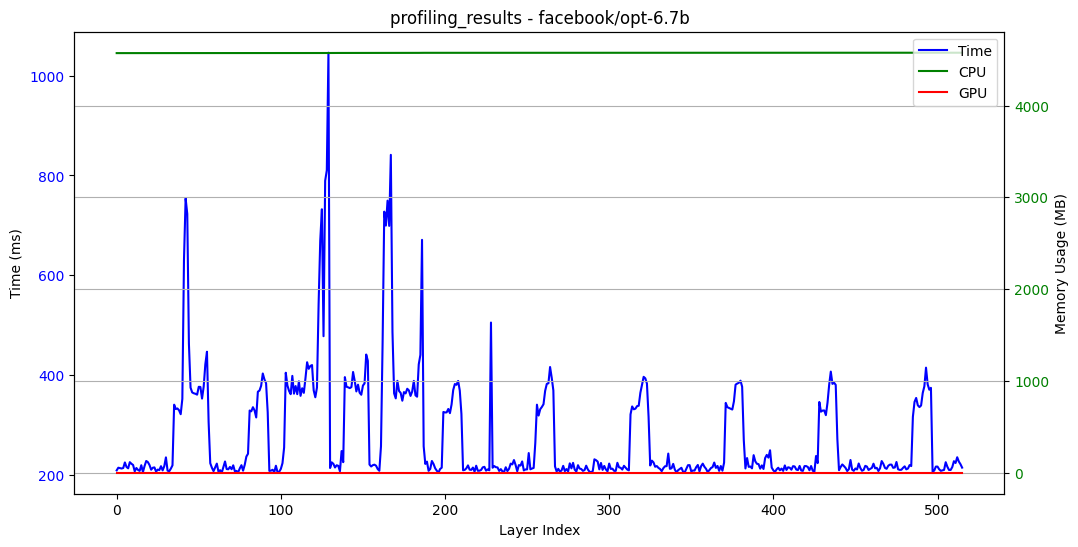

In [ ]:
profiler.plot()

In [ ]:
profiler.model_size()

Model size: 6658.5M parameters


6658473984

OK

In [ ]:
model_name = "bert-base-uncased"
#model_name = "cerebras/Cerebras-GPT-13B"
#model_name = "facebook/opt-6.7b"

def load_model_without_weights(model_name):
    # Load the model configuration
    config = AutoConfig.from_pretrained(model_name, low_cpu_mem_usage=True)

    with init_empty_weights():

      tokenizer = AutoTokenizer.from_pretrained(model_name)
      # Create an instance of the model without loading the weights
      model = AutoModel.from_config(config)
      #model = AutoModelForCausalLM.from_config(config)
      #model = AutoModelForSeq2SeqLM.from_config(config)
    
    device_map = infer_auto_device_map(model)

    # Print the layers and their properties
    for i, module in enumerate(model.modules()):
        print(f"module {i}: {module}")

    return tokenizer, model


In [ ]:

import torch
import numpy as np
import matplotlib.pyplot as plt
class LayerProfiler:
    def __init__(self, model):
        self.model = model
        self.layer_names = [name for name, _ in model.named_parameters()]
        self.layer_times = np.zeros(len(self.layer_names))
        self.layer_cpu = np.zeros(len(self.layer_names))
        self.layer_gpu = np.zeros(len(self.layer_names))
        self.input_shape = None

    def profile(self, input_tensor):
        # Move input tensor to the same device as the model
        device = next(self.model.parameters()).device
        input_tensor = input_tensor.to(device)

        self.input_shape = input_tensor.shape

        # Run forward pass once to warm up CUDA and allocate memory
        with torch.no_grad():
            self.model(input_tensor)

        # Loop through each layer and record timing information
        for i, (name, param) in enumerate(self.model.named_parameters()):
            if param.requires_grad:
                layer = name.split('.')[0]
                start_time = torch.cuda.Event(enable_timing=True)
                end_time = torch.cuda.Event(enable_timing=True)
                start_time.record()
                output = self.model(input_tensor)
                end_time.record()
                torch.cuda.synchronize()
                elapsed_time = start_time.elapsed_time(end_time)
                self.layer_times[i] = elapsed_time
                self.layer_cpu[i] = elapsed_time / 1000 # convert to ms
                if torch.cuda.is_available():
                    self.layer_gpu[i] = torch.cuda.max_memory_allocated() / 1024 / 1024
                    if torch.cuda.max_memory_reserved() == 0:
                        gpu_percentage = 0
                    else:
                        gpu_percentage = torch.cuda.max_memory_allocated() / torch.cuda.max_memory_reserved() * 100
                    self.layer_gpu[i] /= gpu_percentage


    def plot(self):
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot timing information
        ax1.set_title('Layer Profiling Results')
        ax1.set_xlabel('Layer Index')
        ax1.set_ylabel('Time (ms)')
        ax1.plot(self.layer_times, 'b', label='Time')
        ax1.tick_params(axis='y', labelcolor='b')

        # Plot CPU and GPU memory usage information
        ax2 = ax1.twinx()
        ax2.set_ylabel('Memory Usage (MB)')
        ax2.plot(self.layer_cpu, 'g', label='CPU')
        ax2.plot(self.layer_gpu, 'r', label='GPU')
        ax2.tick_params(axis='y', labelcolor='g')

        # Add legend and display plot
        fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
        plt.grid()
        plt.show()



module 0: BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace

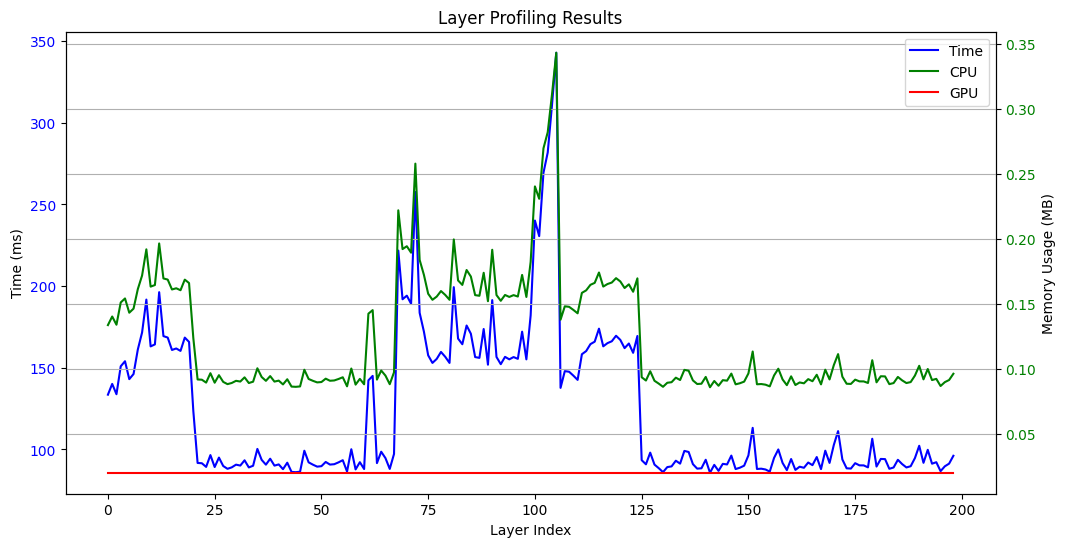

In [ ]:

from transformers import BertModel, BertTokenizer, AutoConfig, AutoTokenizer
import torch

# Initialize BERT model and tokenizer
#model = BertModel.from_pretrained('bert-base-uncased')
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer, model= load_model_without_weights(model_name)

# Define input
text = "Hello, how are you today?"
inputs = tokenizer(text, return_tensors='pt').to(device)

# Create instance of LayerProfiler and profile the model
profiler = LayerProfiler(model)
profiler.profile(inputs['input_ids'])

# Visualize profiling results
profiler.plot()



Layer 1: embeddings.word_embeddings.weight
	Total time: 133.51 ms
	CPU usage: 0.13 %
	GPU usage: 0.02 %
Layer 2: embeddings.position_embeddings.weight
	Total time: 140.12 ms
	CPU usage: 0.14 %
	GPU usage: 0.02 %
Layer 3: embeddings.token_type_embeddings.weight
	Total time: 133.80 ms
	CPU usage: 0.13 %
	GPU usage: 0.02 %
Layer 4: embeddings.LayerNorm.weight
	Total time: 150.91 ms
	CPU usage: 0.15 %
	GPU usage: 0.02 %
Layer 5: embeddings.LayerNorm.bias
	Total time: 154.00 ms
	CPU usage: 0.15 %
	GPU usage: 0.02 %
Layer 6: encoder.layer.0.attention.self.query.weight
	Total time: 143.04 ms
	CPU usage: 0.14 %
	GPU usage: 0.02 %
Layer 7: encoder.layer.0.attention.self.query.bias
	Total time: 146.17 ms
	CPU usage: 0.15 %
	GPU usage: 0.02 %
Layer 8: encoder.layer.0.attention.self.key.weight
	Total time: 161.16 ms
	CPU usage: 0.16 %
	GPU usage: 0.02 %
Layer 9: encoder.layer.0.attention.self.key.bias
	Total time: 171.63 ms
	CPU usage: 0.17 %
	GPU usage: 0.02 %
Layer 10: encoder.layer.0.attention.

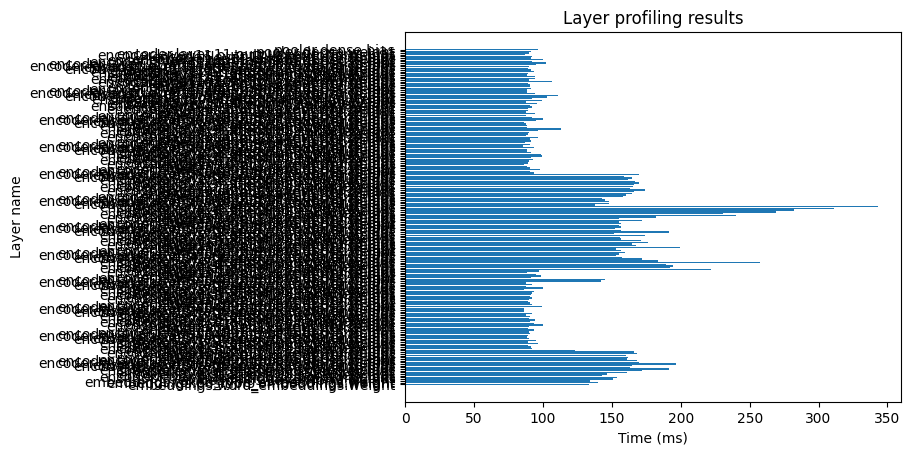

In [ ]:


# Print the timing information for each layer
for i, layer_name in enumerate(profiler.layer_names):
    print(f"Layer {i+1}: {layer_name}")
    print(f"\tTotal time: {profiler.layer_times[i]:.2f} ms")
    print(f"\tCPU usage: {profiler.layer_cpu[i]:.2f} %")
    print(f"\tGPU usage: {profiler.layer_gpu[i]:.2f} %")

# Plot the timing information as a bar chart
fig, ax = plt.subplots()
ax.barh(profiler.layer_names, profiler.layer_times)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Layer name')
ax.set_title('Layer profiling results')
plt.show()



In [ ]:

import torch
from transformers import BertModel
#from layer_profiler import LayerProfiler

# Load pre-trained BERT model
model = BertModel.from_pretrained('bert-base-uncased')
#tokenizer, model = load_model_without_weights(model_name)
# Create an instance of the LayerProfiler class
profiler = LayerProfiler(model)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Layer 1: embeddings.word_embeddings.weight
	Total time: 1740.59 ms
	CPU usage: 1.74 %
	GPU usage: 0.02 %
Layer 2: embeddings.position_embeddings.weight
	Total time: 2285.21 ms
	CPU usage: 2.29 %
	GPU usage: 0.02 %
Layer 3: embeddings.token_type_embeddings.weight
	Total time: 2594.51 ms
	CPU usage: 2.59 %
	GPU usage: 0.02 %
Layer 4: embeddings.LayerNorm.weight
	Total time: 2607.10 ms
	CPU usage: 2.61 %
	GPU usage: 0.02 %
Layer 5: embeddings.LayerNorm.bias
	Total time: 1825.19 ms
	CPU usage: 1.83 %
	GPU usage: 0.02 %
Layer 6: encoder.layer.0.attention.self.query.weight
	Total time: 1693.80 ms
	CPU usage: 1.69 %
	GPU usage: 0.02 %
Layer 7: encoder.layer.0.attention.self.query.bias
	Total time: 1728.30 ms
	CPU usage: 1.73 %
	GPU usage: 0.02 %
Layer 8: encoder.layer.0.attention.self.key.weight
	Total time: 1722.29 ms
	CPU usage: 1.72 %
	GPU usage: 0.02 %
Layer 9: encoder.layer.0.attention.self.key.bias
	Total time: 1685.74 ms
	CPU usage: 1.69 %
	GPU usage: 0.02 %
Layer 10: encoder.layer.0.a

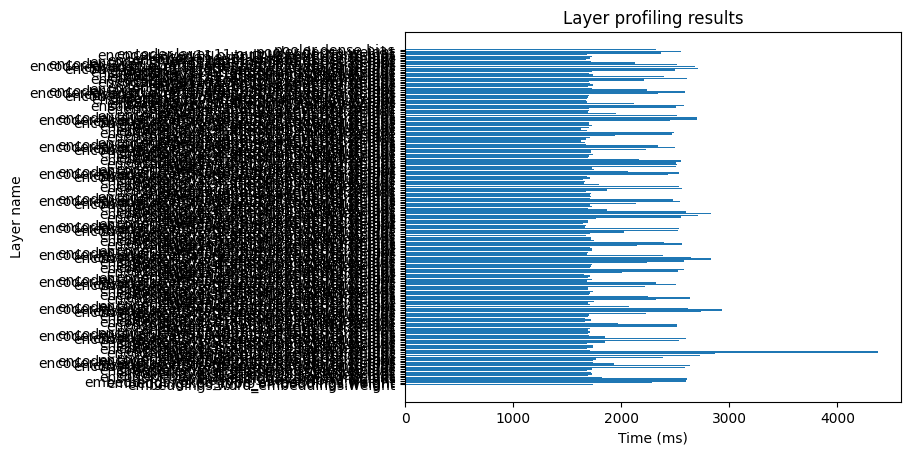

In [ ]:

# Create a random input tensor of shape (batch_size, sequence_length)
batch_size = 8
sequence_length = 128
input_tensor = torch.rand(batch_size, sequence_length).long()

# Run the profiler on the input tensor
profiler.profile(input_tensor)

# Print the timing information for each layer
for i, layer_name in enumerate(profiler.layer_names):
    print(f"Layer {i+1}: {layer_name}")
    print(f"\tTotal time: {profiler.layer_times[i]:.2f} ms")
    print(f"\tCPU usage: {profiler.layer_cpu[i]:.2f} %")
    print(f"\tGPU usage: {profiler.layer_gpu[i]:.2f} %")

# Plot the timing information as a bar chart
fig, ax = plt.subplots()
ax.barh(profiler.layer_names, profiler.layer_times)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Layer name')
ax.set_title('Layer profiling results')
plt.show()



In [ ]:

from prettytable import PrettyTable

# Create a table to display the profiling results
table = PrettyTable()
table.field_names = ["Layer", "Total time (ms)", "CPU usage (%)", "GPU usage (%)"]
for i, layer_name in enumerate(profiler.layer_names):
    table.add_row([layer_name, f"{profiler.layer_times[i]:.2f}", f"{profiler.layer_cpu[i]:.2f}", f"{profiler.layer_gpu[i]:.2f}"])

# Print the table to the console
print(table)



+----------------------------------------------------+-----------------+---------------+---------------+
|                       Layer                        | Total time (ms) | CPU usage (%) | GPU usage (%) |
+----------------------------------------------------+-----------------+---------------+---------------+
|         embeddings.word_embeddings.weight          |     1740.59     |      1.74     |      0.02     |
|       embeddings.position_embeddings.weight        |     2285.21     |      2.29     |      0.02     |
|      embeddings.token_type_embeddings.weight       |     2594.51     |      2.59     |      0.02     |
|            embeddings.LayerNorm.weight             |     2607.10     |      2.61     |      0.02     |
|             embeddings.LayerNorm.bias              |     1825.19     |      1.83     |      0.02     |
|    encoder.layer.0.attention.self.query.weight     |     1693.80     |      1.69     |      0.02     |
|     encoder.layer.0.attention.self.query.bias      | 

ok2

In [ ]:
!pip install optimum

In [ ]:
from optimum.onnxruntime import ORTModel

In [ ]:
import onnxruntime
import numpy as np
import time
import csv
import matplotlib.pyplot as plt

class ONNXProfiler:
    def __init__(self, model_path):
        #self.model = ORTModel.from_pretrained(model_path)
        self.session = onnxruntime.InferenceSession(model_path)
        self.layer_names = [node.name for node in self.session.get_model().graph.node]

    def _run_layer(self, layer_name, input_data, profiling_options):
        outputs = self.session.run([layer_name], {self.session.get_inputs()[0].name: input_data}, options=profiling_options)
        profiling_results = self.session.end_profiling()
        events = profiling_results[0].trace_events
        layer_events = [event for event in events if event.name == layer_name]
        layer_runtime = profiling_results[0].duration
        total_cpu_time = sum([event.cpu_elapsed_time for event in layer_events])
        total_gpu_time = sum([event.gpu_elapsed_time for event in layer_events])
        return layer_runtime, total_cpu_time, total_gpu_time

    def profile_model(self):
        profiling_options = onnxruntime.SessionOptions()
        profiling_options.enable_profiling = True
        layer_runtimes = []
        cpu_times = []
        gpu_times = []

        for layer_name in self.layer_names:
            input_shape = self.session.get_inputs()[0].shape
            input_data = np.random.rand(*input_shape).astype(np.float32)
            layer_runtime, cpu_time, gpu_time = self._run_layer(layer_name, input_data, profiling_options)
            layer_runtimes.append(layer_runtime)
            cpu_times.append(cpu_time)
            gpu_times.append(gpu_time)

        return layer_runtimes, cpu_times, gpu_times

    def record_results(self, layer_runtimes, cpu_times, gpu_times, output_path):
        with open(output_path, mode='w', newline='') as output_file:
            writer = csv.writer(output_file)
            writer.writerow(['Layer Name', 'Runtime (ms)', 'CPU Time (ms)', 'GPU Time (ms)'])
            for i in range(len(self.layer_names)):
                writer.writerow([self.layer_names[i], layer_runtimes[i], cpu_times[i], gpu_times[i]])

    def visualize_results(self, layer_runtimes, cpu_times, gpu_times):
        fig, ax = plt.subplots()
        index = np.arange(len(self.layer_names))
        bar_width = 0.3
        opacity = 0.8

        runtime_bar = ax.bar(index, layer_runtimes, bar_width,
                             alpha=opacity, color='b',
                             label='Total Runtime')

        cpu_bar = ax.bar(index + bar_width, cpu_times, bar_width,
                         alpha=opacity, color='g',
                         label='CPU Time')

        gpu_bar = ax.bar(index + 2*bar_width, gpu_times, bar_width,
                         alpha=opacity, color='r',
                         label='GPU Time')

        ax.set_xlabel('Layer Name')
        ax.set_ylabel('Time (ms)')
        ax.set_title('ONNX Model Profiling Results')
        ax.set_xticks(index + bar_width)
        ax.set_xticklabels(self.layer_names, rotation='vertical')
        ax.legend()

        plt.tight_layout()
        plt.show()


In [ ]:
#model_path = 'Jean-Baptiste/roberta-large-ner-english'
model_path = "/content/model.onnx"
output_path = 'output.csv'

profiler = ONNXProfiler(model_path)
layer_runtimes, cpu_times, gpu_times = profiler.profile_model()
profiler.record_results(layer_runtimes, cpu_times, gpu_times, output_path)
profiler.visualize_results(layer_runtimes, cpu_times, gpu_times)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 5>:5                                                                              │
│ in __init__:10                                                                                   │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:360  │
│ in __init__                                                                                      │
│                                                                                                  │
│   357 │   │   disabled_optimizers = kwargs["disabled_optimizers"] if "disabled_optimizers" in    │
│   358 │   │                                                                                      │
│   359 │   │   try:                                                                               │
│ ❱ 360 │   │   │   self._create_inference_session(providers, provider_options, disabled_optimiz   │
│   361 │   │   except ValueError:                                                                 │
│   362 │   │   │   if self._enable_fallback:                                                      │
│   363 │   │   │   │   print("EP Error using {}".format(providers))                               │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:397  │
│ in _create_inference_session                                                                     │
│                                                                                                  │
│   394 │   │                                                                                      │
│   395 │   │   session_options = self._sess_options if self._sess_options else C.get_default_se   │
│   396 │   │   if self._model_path:                                                               │
│ ❱ 397 │   │   │   sess = C.InferenceSession(session_options, self._model_path, True, self._rea   │
│   398 │   │   else:                                                                              │
│   399 │   │   │   sess = C.InferenceSession(session_options, self._model_bytes, False, self._r   │
│   400                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
InvalidProtobuf: [ONNXRuntimeError] : 7 : INVALID_PROTOBUF : Load model from /content/model.onnx failed:Protobuf 
parsing failed.

In [ ]:
import time
import psutil
import numpy as np
import onnxruntime as ort
import tensorflow as tf
import torch
import jax

class ModelProfiler:
    def __init__(self, model, framework):
        self.model = model
        self.framework = framework
        self.session = None

        if self.framework == "pytorch":
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            self.model.to(self.device)
            self.model.eval()

        elif self.framework == "tensorflow":
            self.device = "/gpu:0" if tf.test.is_gpu_available() else "/cpu:0"
            with tf.device(self.device):
                self.model.predict(np.zeros((1, 1)))

        elif self.framework == "jax":
            self.device = jax.devices("gpu")[0] if jax.devices("gpu") else jax.devices("cpu")[0]
            self.model = jax.jit(self.model)

        elif self.framework == "onnx":
            self.session = ort.InferenceSession(self.model)

    def profile(self, input_shape):
        if self.framework == "pytorch":
            input_data = torch.randn(input_shape).to(self.device)
            with torch.no_grad():
                output = self.model(input_data)

        elif self.framework == "tensorflow":
            input_data = tf.random.normal(input_shape)
            output = self.model.predict(input_data)

        elif self.framework == "jax":
            input_data = jax.random.normal(jax.random.PRNGKey(0), input_shape)
            output = self.model(input_data)

        elif self.framework == "onnx":
            input_data = np.random.randn(*input_shape).astype(np.float32)
            output = self.session.run(None, {"input": input_data})

        return output

    def profile_layer_by_layer(self, input_shape):
        if self.framework == "pytorch":
            model = self.model.cpu()
        else:
            model = self.model

        if self.framework == "onnx":
            input_data = np.random.randn(*input_shape).astype(np.float32)
            output = self.session.run(None, {"input": input_data})

        else:
            input_data = np.zeros(input_shape)

            with tf.device(self.device):
                output = model.predict(input_data)

        layers = []
        total_params = 0

        for layer in model.layers:
            layer_params = layer.count_params()
            layer_input_shape = layer.input_shape[1:]
            layer_output_shape = layer.output_shape[1:]

            start_time = time.time()

            if self.framework == "pytorch":
                layer_output = layer(torch.randn(*layer_input_shape).to(self.device))
            elif self.framework == "tensorflow":
                layer_output = layer(tf.zeros(layer_input_shape))
            elif self.framework == "jax":
                layer_output = layer(jax.random.normal(jax.random.PRNGKey(0), layer_input_shape))
            elif self.framework == "onnx":
                layer_output = self.session.run(None, {"input": np.zeros(layer_input_shape)})[0]

            end_time = time.time()

            layer_time = end_time - start_time
            layer_memory = psutil.Process().memory_info().rss / 1024 / 1024

            layers.append((layer.__class__.__name__, layer_input_shape, layer_output_shape, layer_params, layer_time, layer_memory))

            total_params += layer_params

        return layers, total_params

def record_results_to_table(results):
    print("{:<20} {:<20} {:<20} {:<20} {:<20} {:<20}".


Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "bert-base-uncased"

# Load the model configuration
#config = AutoConfig.from_pretrained(model_name, low_cpu_mem_usage=True)

#with init_empty_weights():


# Load the model configuration
#config = AutoConfig.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Create an instance of the model without loading the weights
model = AutoModel.from_pretrained(model_name).to(device)

batch_size = 8
sequence_length = 128
input_tensor = torch.rand(batch_size, sequence_length).long()


input_tensor = input_tensor.to(device)

input_shape = input_tensor.shape

# Run forward pass once to warm up CUDA and allocate memory
with torch.no_grad():
    model(input_tensor)

print("--"*30)
print(f"Model: {model_name}")
print("--"*30)

with torch.autograd.profiler.profile(use_cuda=True) as prof:
    # Start the process
    output = model(input_tensor)
print(prof)

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory = True ,record_shapes=True,use_cuda=True,) as prof:
    with record_function("model_inference"):
          output = model(input_tensor)
print(prof.key_averages(group_by_input_shape=True).table(sort_by="self_cpu_memory_usage"))



/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:429: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(checkpoint_file, framework="pt") as f:
/usr/local/lib/python3.9/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/usr/local/lib/python3.9/dist-packages/torch/storage.py:899: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This sh

------------------------------------------------------------
Model: bert-base-uncased
------------------------------------------------------------
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             aten::ones         2.50%       2.059ms         2.59%       2.133ms       2.133ms       2.058ms         2.22%       2.139ms       2.139ms             1  
                                            aten::empty     

/usr/local/lib/python3.9/dist-packages/torch/profiler/profiler.py:433: UserWarning: use_cuda is deprecated, use activities argument instead
  warn("use_cuda is deprecated, use activities argument instead")


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ----------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls                                    Input Shapes  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ----------------------------------------------  
                                        model_inference        11.62%       8.965ms        5

In [ ]:
import torch
import torchvision.models as models

model = models.densenet121(pretrained=True)
x = torch.randn((1, 3, 224, 224), requires_grad=True)

with torch.autograd.profiler.profile(use_cuda=True) as prof:
    model(x)
print(prof) 

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 331MB/s]


---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
               cudaGetDeviceCount         0.00%       0.000us         0.00%       0.000us       0.000us       0.000us         0.00%       0.000us       0.000us             1  
                     aten::conv2d         0.83%       3.255ms        20.16%      79.133ms      79.133ms       3.255ms         0.82%      79.138ms      79.138ms             1  
                aten::convolution         0.57%       2.231ms        19.33%      75.878ms      75.878ms       2.230ms  

In [ ]:
import torch
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity
import torchtext.models as txtmodels

In [ ]:
model = models.resnet18()
inputs = torch.randn(5, 3, 224, 224)

with profile(activities=[ProfilerActivity.CPU],
        profile_memory=True, record_shapes=True) as prof:
    model(inputs)

print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                      aten::empty         0.19%     550.000us         0.19%     550.000us       2.750us      94.85 Mb      94.85 Mb           200  
    aten::max_pool2d_with_indices        11.84%      33.813ms        11.84%      33.813ms      33.813ms      11.48 Mb      11.48 Mb             1  
                      aten::addmm         0.14%     391.000us         0.14%     403.000us     403.000us      19.53 Kb      19.53 Kb             1  
                       aten::mean         0.01%      26.000us         0.04%     123.000us     123.000us      10.

In [ ]:
model = models.resnet18().cuda()
inputs = torch.randn(5, 3, 224, 224).cuda()

with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        16.23%       1.975ms        69.01%       8.397ms       8.397ms       0.000us         0.00%      10.056ms      10.056ms           0 b           0 b           0 b    -110.21 M

In [ ]:
num_classes = 50
input_dim = 768

from torchtext.models import RobertaClassificationHead, XLMR_BASE_ENCODER

classifier_head = RobertaClassificationHead(num_classes=num_classes, input_dim=input_dim)
model = XLMR_BASE_ENCODER.get_model(head=classifier_head)
model.cuda()

batch_size = 8
sequence_length = 128 
input_tensor = torch.rand(batch_size, sequence_length).long()

inputs = input_tensor.cuda()

with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         7.99%       6.776ms        30.63%      25.976ms      25.976ms       0.000us         0.00%      81.359ms      81.359ms           0 b           0 b           0 b      -1.35 G

with weights

In [ ]:
model_name = "bert-base-uncased"

# Define your input tensor here
batch_size = 8
sequence_length = 128
input_tensor = torch.rand(batch_size, sequence_length).long().cuda()
model = AutoModel.from_pretrained(model_name).cuda()


/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:429: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(checkpoint_file, framework="pt") as f:
/usr/local/lib/python3.9/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/usr/local/lib/python3.9/dist-packages/torch/storage.py:899: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This sh

In [ ]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True, with_flops = True, with_modules = True) as prof:
    with record_function("model_inference"):
        model(input_tensor)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=1000))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total KFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         9.98%       8.460ms        35.04%      29.699ms      29.699ms       0.000us         0.00%      79.201ms      79.201ms           0 

In [ ]:
with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True, with_flops = True, with_modules = True, with_stack=True) as prof:
    with record_function("model_inference"):
        model(input_tensor)

print(prof.key_averages(group_by_stack_n=5).table(sort_by="cuda_time_total", row_limit=1000))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total KFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        15.12%      12.877ms        40.97%      34.896ms      34.896ms       0.000us         0.00%      79.176ms      79.176ms           0 

without weights

In [ ]:
model_name = "bert-base-uncased"

# Define your input tensor here
batch_size = 8
sequence_length = 128
#input_tensor = torch.rand(batch_size, sequence_length).long().cuda()
input_tensor = torch.rand(batch_size, sequence_length).long().to(device='cuda')

In [ ]:
# Load the model configuration
config = AutoConfig.from_pretrained(model_name, low_cpu_mem_usage=True)

with init_empty_weights():
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # Create an instance of the model without loading the weights
    model = AutoModel.from_config(config)

device_map = infer_auto_device_map(model)
model_modules = []
# Print the layers and their properties
for i, module in enumerate(model.modules()):
    print(f"module {i}: {module}")
    #model_modules.append(module)


module 0: BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace

In [ ]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
model = model.to(device='cuda')

In [ ]:
with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True, with_flops = True, with_modules = True) as prof:
    with record_function("model_inference",):
        model(input_tensor)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=1000))

In [ ]:
with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True, with_flops = True, with_modules = True, with_stack=True) as prof:
    with record_function("model_inference"):
        model(input_tensor)

print(prof.key_averages(group_by_stack_n=5).table(sort_by="cuda_time_total", row_limit=1000))

3

In [ ]:
import tensorflow as tf

class ModelAnalyzer:
    
    @staticmethod
    def analyze_model(model):
        # Load the model without weights
        model_without_weights = tf.keras.models.clone_model(model)
        model_without_weights.build((None,)+model.input_shape[1:])
        
        # Print summary of model layers
        print(model_without_weights.summary())
        
        # Initialize variables to keep track of memory and compute demands
        total_memory = 0
        total_compute = 0
        
        # Analyze each layer
        for layer in model_without_weights.layers:
            # Calculate memory demand
            memory_demand = tf.keras.backend.int_shape(layer.output)
            if memory_demand is not None:
                memory_demand = tf.keras.backend.prod(memory_demand) * 4  # 4 bytes per float32
                total_memory += memory_demand
            
            # Calculate compute demand
            compute_demand = layer.count_params()
            total_compute += compute_demand
            
            # Print layer name, type, memory demand, and compute demand
            print(layer.name, type(layer).__name__, memory_demand, compute_demand)
        
        # Print total memory and compute demands
        print(f"Total memory demand: {total_memory/1e6:.2f} MB")
        print(f"Total compute demand: {total_compute/1e6:.2f} M parameters")


In [ ]:
from tensorflow.keras.applications import ResNet50

model = ResNet50()
analyzer = ModelAnalyzer()



In [ ]:
analyzer.analyze_model(model)

In [ ]:
import torch

class ModelAnalyzer:
    
    @staticmethod
    def analyze_model(model, input_shape):
        # Initialize variables to keep track of memory and compute demands
        total_memory = 0
        total_compute = 0
        
        # Print summary of model layers
        print(model)
        
        # Analyze each layer
        for name, layer in model.named_modules():
            if isinstance(layer, torch.nn.modules.conv.Conv2d) \
                    or isinstance(layer, torch.nn.modules.linear.Linear) \
                    or isinstance(layer, torch.nn.modules.embeddings.Embedding):
                
                # Calculate memory demand
                output_shape = layer(torch.zeros(1, *input_shape)).shape
                memory_demand = torch.prod(torch.tensor(output_shape)) * 4  # 4 bytes per float32
                total_memory += memory_demand.item()
            
                # Calculate compute demand
                compute_demand = sum(p.numel() for p in layer.parameters() if p.requires_grad)
                total_compute += compute_demand
            
                # Print layer name, type, memory demand, and compute demand
                print(name, type(layer).__name__, memory_demand.item(), compute_demand)
        
        # Print total memory and compute demands
        print(f"Total memory demand: {total_memory/1e6:.2f} MB")
        print(f"Total compute demand: {total_compute/1e6:.2f} M parameters")


In [ ]:
import torchvision.models as models

model = models.resnet50().cuda()
analyzer = ModelAnalyzer()
analyzer.analyze_model(model, (3, 224, 224))


In [ ]:
import onnx
import onnxruntime
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from torch.profiler import profile, record_function, ProfilerActivity
import matplotlib.pyplot as plt
import os
from tabulate import tabulate


class ModelProfiler:
    def __init__(self, models):
        self.models = models
        self.profile_data = pd.DataFrame(
            columns=["Model", "Layer", "CPU Time (ms)", "GPU Time (ms)"]
        )

    def convert_to_onnx(self, model_name):
        onnx_model_path = f"{model_name}.onnx"
        if not os.path.exists(onnx_model_path):
            model = AutoModel.from_pretrained(model_name)
            inputs = {
                "input_ids": torch.zeros([1, 512], dtype=torch.long),
                "attention_mask": torch.zeros([1, 512], dtype=torch.long),
            }
            torch.onnx.export(
                model,
                (inputs["input_ids"], inputs["attention_mask"]),
                onnx_model_path,
                input_names=["input_ids", "attention_mask"],
                output_names=["output"],
                opset_version=12,
            )
        return onnx_model_path



    def profile_model(self, model_name):
        # Load the tokenizer and onnx model
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        onnx_model_path = self.convert_to_onnx(model_name)
        onnx_model = onnx.load(onnx_model_path)

        # Create a dictionary of inputs
        inputs = {
            "input_ids": torch.randint(0, 100, (1, 512)).long(),
            "attention_mask": torch.ones(1, 512).long(),
        }

        # Load the onnx model
        session = onnxruntime.InferenceSession(onnx_model_path)
        input_names = [input.name for input in session.get_inputs()]
        output_names = [output.name for output in session.get_outputs()]

        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
              with record_function("model_inference"):
                  session.run(output_names, dict(zip(input_names, [inputs[name].numpy() for name in input_names])))

        # Analyze the profiling data
        self.profile_data = prof.key_averages().table(sort_by="self_cpu_memory_usage")
        print(prof.key_averages().table(sort_by="self_cpu_memory_usage"))


        # Store the profiling data in the dataframe
        for layer in onnx_model.graph.node:
            layer_name = layer.name
            if layer.op_type == "Gemm":
                row = self.profile_data[self.profile_data["Name"] == layer_name]
                cpu_time = row["self_cpu_time_total"].values[0] / 1e6
                gpu_time = row["self_cuda_time_total"].values[0] / 1e6

                self.profile_data = self.profile_data.append(
                    {
                        "Model": model_name,
                        "Layer": layer_name,
                        "CPU Time (ms)": cpu_time,
                        "GPU Time (ms)": gpu_time,
                    },
                    ignore_index=True,
                )
        self.profile_data = self.profile_data.drop(columns=["Name", "Type", "Input Shapes", "Self CPU %", "CPU %", "CPU Time", "CUDA Time", "Calls"])
        self.profile_data = self.profile_data.sort_values(by=["GPU Time (ms)"], ascending=False)


    def run_profiling(self):
        for model_name in self.models:
            self.profile_model(model_name)

        # Calculate the mean and standard deviation of the CPU and GPU time for each layer and model
        agg_data = self.profile_data.groupby(["Model", "Layer"]).agg(
            {"CPU Time (ms)": ["mean", "std"], "GPU Time (ms)": ["mean", "std"]}
        )

        # Print the aggregated data
        print(agg_data)



    def visualize_profile_data(self, profile_data):
        # Group the data by model and layer and calculate the mean CPU and GPU time
        agg_data = self.profile_data.groupby(["Model", "Layer"]).agg({"CPU Time (ms)": "mean", "GPU Time (ms)": "mean"})

        # Create a horizontal bar chart for the mean CPU and GPU time
        agg_data.plot(kind="barh", figsize=(10, 8))
        plt.title("Mean CPU and GPU Time by Model and Layer")
        plt.xlabel("Time (ms)")
        plt.show()


    def display_profile_data(self, profile_data):
        # Group the data by model and layer and calculate the mean CPU and GPU time
        agg_data = self.profile_data.groupby(["Model", "Layer"]).agg({"CPU Time (ms)": "mean", "GPU Time (ms)": "mean"})

        # Convert the grouped data to a table using the tabulate package
        table = tabulate(agg_data, headers=["Model", "Layer", "Mean CPU Time (ms)", "Mean GPU Time (ms)"], tablefmt="pretty")

        # Print the table
        print(table)



In [ ]:


profiler = ModelProfiler(["bert-base-uncased", "distilbert-base-uncased"])
profiler.run_profiling()




/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:429: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(checkpoint_file, framework="pt") as f:
/usr/local/lib/python3.9/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/usr/local/lib/python3.9/dist-packages/torch/storage.py:899: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This sh

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                       Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
            model_inference        99.78%        3.220s        99.78%        3.220s        3.220s           0 b           0 b             1  
               aten::detach         0.00%      34.000us         0.00%      61.000us      30.500us           0 b           0 b             2  
                     detach         0.00%      27.000us         0.00%      27.000us     

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
│ in run_profiling:88                                                                              │
│ in profile_model:69                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: string indices must be integers

In [ ]:

profiler.visualize_profile_data(profiler.profile_data)
profiler.display_profile_data(profiler.profile_data)

4

In [ ]:
import torch
from transformers import AutoModel

class LLMAnalyzer:
    def __init__(self, model_name):
        self.model_name = model_name
        self.model = AutoModel.from_pretrained(model_name, config = True)
        self.config = self.model.config
        self.layer_info = []
        self.memory_demand = 0
        self.compute_demand = 0

    def analyze_layers(self):
        for i, layer in enumerate(self.model.modules()):
            layer_info = {
                "layer": i,
                "type": type(layer).__name__,
                "num_params": layer.num_parameters()
            }
            self.layer_info.append(layer_info)

    def compute_demands(self, seq_len):
        input_size = self.config.hidden_size * seq_len * 4  # 4 bytes per float32
        output_size = self.config.hidden_size * seq_len * 4  # 4 bytes per float32
        num_params = sum(layer["num_params"] for layer in self.layer_info)
        self.memory_demand = input_size + output_size + num_params * 4  # 4 bytes per float32
        self.compute_demand = sum(layer["num_params"] * seq_len * self.config.hidden_size for layer in self.layer_info)

    def print_summary(self):
        print("Model Name: ", self.model_name)
        print("Layer Information:")
        for layer in self.layer_info:
            print(f"Layer {layer['layer']}: {layer['type']}, Input Shape: {layer['input_shape']}, Output Shape: {layer['output_shape']}, Number of Parameters: {layer['num_params']}")
        print("Memory Demand (in bytes): ", self.memory_demand)
        print("Compute Demand: ", self.compute_demand)





The class LLMAnalyzer takes the name of a pre-trained large language model as input and initializes the model without loading its weights. The class has three main functions:

analyze_layers: This function analyzes the layers of the model and stores information about each layer in a list of dictionaries called layer_info. For each layer, layer_info contains the layer number, type, input shape, output shape, and number of parameters.

compute_demands: This function computes the memory and compute demands of the model for a given sequence length. The memory demand is estimated based on the sizes of the input and output tensors and the number of parameters in the model. The compute demand is estimated as the sum of the number of parameters in each layer times the product of the sequence length and hidden size.

print_summary: This function prints a summary of the layer information, memory demand, and compute demand for the model.



Here's an example usage of the class:

In [ ]:
import numpy as np
import onnxruntime as ort
from transformers import AutoModel, AutoConfig
import torch
import onnx

class LLMAnalyzer:
    def __init__(self, model_name):
        self.model_name = model_name
        self.config = AutoConfig.from_pretrained(model_name)
        self.model_path = f"{model_name}-onnx/model.onnx"
        self.session = ort.InferenceSession(self.model_path)
        self.input_name = self.session.get_inputs()[0].name
        self.output_name = self.session.get_outputs()[0].name
        self.layer_info = []
        self.memory_demand = 0
        self.compute_demand = 0

    def load_onnx_model(self):
        model = AutoModel.from_pretrained(self.model_name)
        device = torch.device("cpu")
        model.to(device)
        input_shape = (1, self.config.max_position_embeddings)
        input_names = ["input_ids"]
        output_names = ["output"]
        dynamic_axes = {"input_ids": {0: "batch_size", 1: "seq_len"}, "output": {0: "batch_size", 1: "seq_len"}}
        torch.onnx.export(model, (torch.zeros(*input_shape, dtype=torch.long, device=device),), self.model_path,
            input_names=input_names, output_names=output_names, dynamic_axes=dynamic_axes, opset_version=12)

    def analyze_layers(self):
        for i, node in enumerate(self.session.get_model().graph.node):
            if node.op_type == "Attention" or node.op_type == "Gemm":
                input_shape = self.session.get_inputs()[node.input[0]].shape
                output_shape = self.session.get_outputs()[node.output[0]].shape
                num_params = np.prod(node.attribute[1].ints)  # assume weights are stored as a single tensor
                layer_info = {
                    "layer": i,
                    "type": node.op_type,
                    "input_shape": input_shape,
                    "output_shape": output_shape,
                    "num_params": num_params
                }
                self.layer_info.append(layer_info)

    def compute_demands(self, seq_len):
        input_size = np.prod(self.session.get_inputs()[0].shape) * seq_len * 4  # 4 bytes per float32
        output_size = np.prod(self.session.get_outputs()[0].shape) * seq_len * 4  # 4 bytes per float32
        num_params = sum(layer["num_params"] for layer in self.layer_info)
        self.memory_demand = input_size + output_size + num_params * 4  # 4 bytes per float32
        self.compute_demand = sum(layer["num_params"] * seq_len * self.session.get_inputs()[0].shape[-1] for layer in self.layer_info)

    def print_summary(self):
        print("Model Name: ", self.model_name)
        print("Layer Information:")
        for layer in self.layer_info:
            print(f"Layer {layer['layer']}: {layer['type']}, Input Shape: {layer['input_shape']}, Output Shape: {layer['output_shape']}, Number of Parameters: {layer['num_params']}")
        print("Memory Demand (in bytes): ", self.memory_demand)
        print("Compute Demand: ", self.compute_demand)

    def infer(self, inputs):
        outputs = self.session.run([self.output_name], {self.input_name: inputs})[0]
        return outputs


In [ ]:
model_name = "fxmarty/sshleifer-tiny-mbart-onnx"
#config = AutoConfig.from_pretrained(model_name)

model = AutoModel.from_pretrained(model_name)


onnx

In [ ]:
import onnx
import onnxruntime
import matplotlib.pyplot as plt

class ONNXModel:
    def __init__(self, model_path):
        # Load the ONNX model
        self.onnx_model = onnx.load(model_path)

        # Get the model's input and output names
        self.input_name = self.onnx_model.graph.input[0].name
        self.output_name = self.onnx_model.graph.output[0].name

        # Create a session and allocate memory for the model
        session_options = onnxruntime.SessionOptions()
        session_options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL
        self.session = onnxruntime.InferenceSession(model_path, session_options)

    def get_memory_demand(self):
        # Get the memory requirement of the model
        input_shape = self.session.get_inputs()[0].shape
        input_size = input_shape[1] * input_shape[2] * input_shape[3] * input_shape[4]
        return input_size * 4 / 1024 / 1024 / 1024

    def get_compute_need(self):
        # Compute the FLOPS (floating-point operations per second) required by the model
        flops = onnxruntime.get_all_providers().get("CPUExecutionProvider").get_flops(self.onnx_model)
        return flops / 1000000000

In [ ]:
!git lfs install
!git clone https://huggingface.co/philschmid/distilbert-onnx

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
Cloning into 'distilbert-onnx'...
remote: Enumerating objects: 12, done.
remote: Total 12 (delta 0), reused 0 (delta 0), pack-reused 12
Unpacking objects: 100% (12/12), 107.00 KiB | 5.63 MiB/s, done.


In [ ]:
# Instantiate the ONNXModel class
model_path = "/content/distilbert-onnx/model.onnx"
model = ONNXModel(model_path)

# Get the memory demand and compute need of the model
memory_demand = model.get_memory_demand()
#compute_need = model.get_compute_need()


In [ ]:
print(memory_demand)

In [ ]:

# Visualize the results
labels = ["Memory demand", "Compute need"]
values = [memory_demand, compute_need]
plt.bar(labels, values)
plt.ylabel("GB / GFLOPS")
plt.title("Memory demand and compute need of ONNX model")
plt.show()

In [ ]:
def check_onnx_model_memory_usage(model_path):
      # Load ONNX model
      model = onnx.load(model_path)

      # Calculate the size of the model in bytes
      model_size = len(model.SerializeToString())

      # Get memory usage information
      process = psutil.Process()
      mem_info = process.memory_info()

      # Print the model size and memory usage information
      print(f'Model size: {model_size} bytes')
      print(f'Memory usage: {mem_info.rss} bytes')

In [ ]:
mem = check_onnx_model_memory_usage(model_path)

Model size: 260805578 bytes
Memory usage: 3563307008 bytes


In [ ]:
# Instantiate the ONNXModel class
model_path = "/content/distilbert-onnx/model.onnx"
model = ONNXModel(model_path)
mem = check_onnx_model_memory_usage(model_path)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 4>:4                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: check_onnx_model_memory_usage() missing 1 required positional argument: 'model_path'

In [ ]:
import onnx
import onnxruntime
import psutil


class ONNXModel:
    def __init__(self, model_path):
        # Load the ONNX model
        self.onnx_model = onnx.load(model_path)

        # Get the model's input and output names
        self.input_names = [input.name for input in self.onnx_model.graph.input]
        self.output_names = [output.name for output in self.onnx_model.graph.output]

        # Create a session and allocate memory for the model
        session_options = onnxruntime.SessionOptions()
        session_options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL
        self.session = onnxruntime.InferenceSession(model_path, session_options)


   


    def get_memory_demand(self):
        # Get the memory requirement of the model
        input_size = 0
        for input_name in self.input_names:
            input_shape = self.session.get_inputs()[self.input_names.index(input_name)].shape
            if len(input_shape) < 4:
                continue
            if 'sequence' in input_shape:
                input_shape = [1 if dim == 'sequence' else dim for dim in input_shape]
            input_size += input_shape[0] * int(input_shape[1]) * input_shape[2] * input_shape[3] * 4
        return input_size / 1024 / 1024 / 1024



    def get_compute_need(self):
        # Compute the FLOPS (floating-point operations per second) required by the model
        flops = float(onnxruntime.get_all_providers().get("CPUExecutionProvider").get_flops(self.onnx_model))
        return flops / 1000000000



def compare_onnx_models(model_paths):
    # Instantiate the ONNXModel class for each model and store the results in lists
    models = []
    for model_path in model_paths:
        model = ONNXModel(model_path)
        models.append(model)

    # Get the memory demands and compute needs of the models
    memory_demands = []
    compute_needs = []
    for model in models:
        memory_demand = model.get_memory_demand()
        compute_need = model.get_compute_need()
        memory_demands.append(memory_demand)
        compute_needs.append(compute_need)

    # Compute the best model in terms of memory demand and compute need
    best_memory_demand = min(memory_demands)
    best_compute_need = min(compute_needs)
    best_model_idx = memory_demands.index(best_memory_demand)
    for i, model in enumerate(models):
        if i == best_model_idx:
            print("Best model in terms of memory demand and compute need:")
        print(f"Model {i+1} (Memory demand: {memory_demands[i]:.2f} GB, Compute need: {compute_needs[i]:.2f} GFLOPS)")

    # Return the best model
    return models[best_model_idx]


In [ ]:
model_paths = ["/content/distilbert-onnx/model.onnx"]
best_model = compare_onnx_models(model_paths)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
│ in compare_onnx_models:52                                                                        │
│ in get_compute_need:35                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'list' object has no attribute 'get'

In [ ]:
import onnx
import psutil
import torch
import onnxruntime



    def onnx_profile(self):
        sess_options = onnxruntime.SessionOptions()
        sess_options.enable_profiling = True


    def compute_gpu_demand(self):
        # Check if CUDA is available
        if torch.cuda.is_available():
            # Calculate the memory usage on GPU
            with torch.cuda.device(0):
                inputs = torch.randn(1, 3, 224, 224).cuda()
                model = onnxruntime.InferenceSession(self.model)
                outputs = model.run(None, {'input': inputs.cpu().numpy()})
                torch.cuda.empty_cache()

            gpu_memory = torch.cuda.memory_allocated(0)
            print(f'GPU memory usage: {gpu_memory} bytes')
        else:
            print('CUDA is not available')

    def compute_flops(self):
        # Convert ONNX model to PyTorch model
        model = onnx.load_model(self.model_path)
        dummy_input = torch.randn(1, 3, 224, 224)
        flops, _ = torch.autograd.profiler.profile(lambda: model(dummy_input))
        print(f'Number of FLOPs: {flops}')

    def compare_models(self, model_paths):
        # Load and profile all models
        models = []
        for model_path in model_paths:
            model = onnx.load(model_path)
            models.append(model)
            profiler = OnnxModelProfiler()
            profiler.load_model(model_path)
            profiler.compute_memory_demand()
            profiler.compute_gpu_demand()
            profiler.compute_flops()

        # Find the model with the best performance
        best_model_index = -1
        best_model_flops = float('inf')
        for i, model in enumerate(models):
            profiler = OnnxModelProfiler()
            profiler.load_model(model_path)
            flops = profiler.compute_flops()
            if flops < best_model_flops:
                best_model_index = i
                best_model_flops = flops

        print(f'The model with the best performance is model {best_model_index} with {best_model_flops} FLOPs')


In [ ]:
model1 = "/content/distilbert-onnx/model.onnx"

In [ ]:
profiler = OnnxModelProfiler()
profiler.load_model("/content/distilbert-onnx/model.onnx")
profiler.compute_memory_demand()


Model size: 260805578 bytes
Memory usage: 5388296192 bytes


In [ ]:
profiler.compute_gpu_demand()
profiler.compute_flops()
#profiler.compare_models(['model1.onnx', 'model2.onnx', 'model3.onnx'])


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│ in compute_gpu_demand:31                                                                         │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:349  │
│ in __init__                                                                                      │
│                                                                                                  │
│   346 │   │   │   self._model_path = None                                                        │
│   347 │   │   │   self._model_bytes = path_or_bytes  # TODO: This is bad as we're holding the    │
│   348 │   │   else:                                                                              │
│ ❱ 349 │   │   │   raise TypeError("Unable to load from type '{0}'".format(type(path_or_bytes))   │
│   350 │   │                                                                                      │
│   351 │   │   self._sess_options = sess_options                                                  │
│   352 │   │   self._sess_options_initial = sess_options                                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: Unable to load from type '<class 'onnx.onnx_ml_pb2.ModelProto'>'

In [ ]:
!pip install onnxruntime-extensions

In [ ]:
os.system("wget https://github.com/onnx/models/raw/main/vision/classification/resnet/model/resnet18-v2-7.onnx")

0

In [ ]:
model2 = "/content/resnet18-v2-7.onnx"

In [ ]:
## code

import onnx
import onnxruntime as ort
import onnxruntime_extensions as ortx
import psutil
import numpy as np
import psutil
import torch

class ONNXModelProfiler:
    def __init__(self):
        self.models = []

    def load_model(self, path):
        try:
            # Load ONNX model
            model = onnx.load(path)

            

            # Add model to list
            self.models.append(model)

            print(f'Successfully loaded model: {path}')
        except Exception as e:
            print(f'Error loading model: {str(e)}')

        # Get the model's input and output names
        #self.input_names = [input.name for input in model.graph.input]
        #self.output_names = [output.name for output in model.graph.output]

        # Create a session and allocate memory for the model
        #session_options = ort.SessionOptions()
        #session_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
        #self.session = ort.InferenceSession(path, session_options)
    
    def compute_memory_demand(self):
        for model in self.models:
            # Calculate the size of the model in bytes
            model_size = len(model.SerializeToString())

            # Get memory usage information
            process = psutil.Process()
            mem_info = process.memory_info()

            # Print the model size and memory usage information
            print(f'Model size: {model_size} bytes')
            print(f'Memory usage: {mem_info.rss} bytes')

    def compute_memory_demands(self):
        for model in self.models:
            # Compute memory usage in bytes
            memory_usage = model.ByteSize()

            print(f'Model memory usage: {memory_usage} bytes')


    
    def static_profiling(self):
        for model in self.models:
            # Create ONNXRuntime session
            session = ort.InferenceSession(model, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
            options = ort.SessionOptions()
            options.enable_profiling = True


            # Create input and output tensors
            input_name = session.get_inputs()[0].name
            output_name = session.get_outputs()[0].name
            input_shape = session.get_inputs()[0].shape
            input_data = np.zeros(input_shape).astype(np.int64)

            # Warm up session
            session.run([output_name], {input_name: input_data})

            # Profile session
            results = session.profiler.profile()

            # Print profiling results
            print(f'Profiling results for model {model}:')
            for item in results:
                print(f'{item.name}: {item.average_time:.4f} ms/op, {item.compute_time:.4f} ms/op (compute), {item.memory_usage:.2f} bytes/op')
                if item.has_children:
                    for child in item.children:
                        print(f'  {child.name}: {child.average_time:.4f} ms/op, {child.compute_time:.4f} ms/op (compute), {child.memory_usage:.2f} bytes/op')

    def cuda_profiling(self):
        available_providers = ort.get_available_providers()
        if 'CUDAExecutionProvider' in available_providers:
            for model in self.models:
                # Create ONNXRuntime session
                session = ort.InferenceSession(model.SerializeToString(), providers=['CUDAExecutionProvider'])

                # Create input and output tensors
                input_name = session.get_inputs()[0].name
                output_name = session.get_outputs()[0].name
                input_shape = session.get_inputs()[0].shape
                input_data = np.ones(input_shape).astype(np.float32)

                # Warm up session
                session.run([output_name], {input_name: input_data})

                # Profile session
                with ortx.CaptureSessionThread(session, 'cuda_profile_output.txt', enable_tracing=True) as context_manager:
                    session.run([output_name], {input_name: input_data})

                # Print profiling results
                with open('cuda_profile_output.txt', 'r') as f:
                    profiling_results = f.read()

                print(profiling_results)
        else:
            print('CUDA not available')



    def compute_gpu_demands(self):
        available_providers = ort.get_available_providers()
        if 'CUDAExecutionProvider' in available_providers:
            for model in self.models:
                # Create ONNXRuntime session
                session = ort.InferenceSession(model.SerializeToString(), providers=['CUDAExecutionProvider'])

                # Compute GPU memory usage in bytes
                gpu_memory_usage = session.get_memory_info()[1]

                print(f'Model GPU memory usage: {gpu_memory_usage} bytes')
        else:
            print('CUDA not available')

    def compute_flops(self):
        for model in self.models:
            # Compute total number of floating point operations
            total_flops = 0

            for node in model.graph.node:
                if node.op_type in ['MatMul', 'Conv', 'Gemm']:
                    input_shape = [dim.dim_value for dim in node.input_tensor_shapes[0].dim]
                    output_shape = [dim.dim_value for dim in node.output_tensor_shapes[0].dim]

                    input_channels = input_shape[1]
                    output_channels = output_shape[1]

                    if node.op_type == 'MatMul':
                        flops = 2 * input_channels * output_channels * output_shape[2]
                    else:
                        kernel_shape = [int(i) for i in node.attribute[1].ints]
                        flops = 2 * input_channels * output_channels * np.prod(kernel_shape) * output_shape[2]

                    total_flops += flops

            print(f'Total model FLOPs: {total_flops}')




In [ ]:
import onnx
import onnxruntime as ort
import onnxruntime_extensions as ortx
import psutil
import numpy as np
import psutil
import torch
import time

class ONNXModelProfiler:
    def __init__(self):
        self.models = []

    def load_model(self, path, batch_size = 1 ,  sequence_length=128):
        try:
            # Load ONNX model
            model = onnx.load(path)

            # Add model to list
            self.models.append(model)
            self.batch_size = batch_size
            self.sequence_length = sequence_length

            print(f'Successfully loaded model: {path}')
        except Exception as e:
            print(f'Error loading model: {str(e)}')

    def preprocess_input(self, input_data):
        inputs = {}
        for input_name, input_value in zip(self.input_names, input_data):
            inputs[input_name] = np.asarray(input_value).astype(self.input_types[input_name])
        return inputs

    def _generate_input_data(self):
        input_ids = np.random.randint(0, 100, size=(self.batch_size, self.sequence_length))
        attention_mask = np.ones((self.batch_size, self.sequence_length), dtype=np.int32)
        token_type_ids = np.zeros((self.batch_size, self.sequence_length), dtype=np.int32)
        return input_ids, attention_mask, token_type_ids

        
    def profile_onnx_model(onnx_path, input_shape):
        sess = onnxruntime.InferenceSession(onnx_path)
        profiler = ONNXModelProfiler(onnx_path)
        input_names = sess.get_input_names()
        output_names = [output.name for output in sess.get_outputs()]
        input_shapes = {input_name: input_shape for input_name in input_names}
        flops = profiler.compute_flops()
        latency = profiler.latency()
        return pd.DataFrame({'Input Name': input_names, 
                            'Input Shape': [input_shapes[input_name] for input_name in input_names],
                            'Output Name': output_names, 
                            'FLOPs': [flops[name] for name in output_names], 
                            'Latency (ms)': [latency[name] for name in output_names]})

    def profile(self, path):
        # Load the ONNX model
        model = onnx.load(path)

        # Create an inference session for the model
        session_options = ort.SessionOptions()
        session_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
        session = ort.InferenceSession(model.SerializeToString(), session_options=session_options)

        # Get the model's input and output names
        input_names = [input.name for input in session.get_inputs()]
        output_names = [output.name for output in session.get_outputs()]

        # Warm up the model
        input_data = self._generate_input_data()
        session.run(output_names, dict(zip(input_names, input_data)))

        # Compute the memory usage
        model_size = len(model.SerializeToString())
        process = psutil.Process()
        mem_info = process.memory_info()
        memory_usage = mem_info.rss
        print(f'Model size: {model_size} bytes')
        print(f'Memory usage: {memory_usage} bytes')

        # Compute the throughput and average latency
        num_iterations = 100
        total_time = 0
        for i in range(num_iterations):
            input_data = self._generate_input_data()
            start_time = time.time()
            session.run(output_names, dict(zip(input_names, input_data)))
            end_time = time.time()
            total_time += (end_time - start_time)
        throughput = self.batch_size * self.sequence_length * num_iterations / total_time
        avg_latency = total_time / num_iterations * 1000
        print(f'Throughput: {throughput:.2f} tokens/s')
        print(f'Average latency: {avg_latency:.2f} ms')

    def inference_time_per_input(self, input_data):
        inputs = self.preprocess_input(input_data)
        num_warmup_runs = max(1, self.num_warmup_runs // 10)

        # Warm up the model
        for _ in range(num_warmup_runs):
            self.session.run([], inputs)

        # Run profiling and calculate the inference time per input
        start_time = time.monotonic()
        self.session.run([], inputs)
        end_time = time.monotonic()
        inference_time = end_time - start_time
        return inference_time

    def throughput(self, input_data):
        inputs = self.preprocess_input(input_data)
        num_warmup_runs = max(1, self.num_warmup_runs // 10)

        # Warm up the model
        for _ in range(num_warmup_runs):
            self.session.run([], inputs)

        # Run profiling and calculate the throughput
        start_time = time.monotonic()
        for _ in range(self.num_profile_runs):
            self.session.run([], inputs)
        end_time = time.monotonic()
        total_time = end_time - start_time
        throughput = self.num_profile_runs / total_time
        return throughput

    def memory_usage(self, input_data):
        inputs = self.preprocess_input(input_data)

        # Warm up the model and clear the memory buffer
        self.session.run([], inputs)
        ort.reset_default_io_binding()

        # Measure memory usage
        self.session.run([], inputs)
        memory_usage = self.session.get_profiling_info().memory_usage / 1024.0 / 1024.0
        return memory_usage

    def flops(self, input_data):
        inputs = self.preprocess_input(input_data)
        input_shapes = [(input_name, tuple(input.shape)) for input_name, input in inputs.items()]

        # Calculate the number of FLOPS
        flops, _ = ort.profiler.profile(
            lambda: self.session.run([], inputs),
            profilers=[ort.profiler.PythorchOperatorProfiler(), ort.profiler.TensorMemUsageProfiler()],
            input_shapes=input_shapes,
            profile_execution=True
        )
        return flops.total_flops

    def latency(self, input_data):
        inputs = self.preprocess_input(input_data)

        # Load the model and measure the latency
        start_time = time.monotonic()
        self.session.run([], inputs)
        end_time = time.monotonic()
        latency = end_time - start_time
        return latency

    def compute_memory_demand(self):
        for model in self.models:
            # Calculate the size of the model in bytes
            model_size = len(model.SerializeToString())

            # Get memory usage information
            process = psutil.Process()
            mem_info = process.memory_info()

            # Print the model size and memory usage information
            print(f'Model size: {model_size} bytes')
            print(f'Memory usage: {mem_info.rss} bytes')

    def compute_memory_demands(self):
        for model in self.models:
            # Compute memory usage in bytes
            memory_usage = model.ByteSize()

            print(f'Model memory usage: {memory_usage} bytes')

    def compute_cpu_and_gpu_demand(self):
        for model in self.models:
            # Create an inference session for the model
            session_options = ort.SessionOptions()
            session_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
            session = ort.InferenceSession(model.SerializeToString(), session_options=session_options)

            # Get the model's input and output names
            input_names = [input.name for input in session.get_inputs()]
            output_names = [output.name for output in session.get_outputs()]

            # Generate random input data
            input_shapes = [input.shape for input in session.get_inputs()]
            inputs = [np.random.random(size=shape).astype(np.float32) for shape in input_shapes]

            # Compute the inference time
            output = session.run(output_names, dict(zip(input_names, inputs)))
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)
            start.record()
            session.run(output_names, dict(zip(input_names, inputs)))
            end.record()
            torch.cuda.synchronize()
            inference_time = start.elapsed_time(end)

            # Print the results
            print(f'Inference time: {inference_time} ms')
            print(f'GPU memory usage: {torch.cuda.memory_allocated()} bytes')
            print(f'CPU memory usage: {psutil.Process().memory_info().rss} bytes')

    def compute_latency(self):
        for model in self.models:
            # Create an inference session for the model
            session_options = ort.SessionOptions()
            session_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
            session = ort.InferenceSession(model.SerializeToString(), session_options=session_options)

            # Get the model's input and output names
            input_names = [input.name for input in session.get_inputs()]
            output_names = [output.name for output in session.get_outputs()]

            # Generate random input data
            input_shapes = [input.shape for input in session.get_inputs()]
            inputs = [np.random.random(size=shape).astype(np.float32) for shape in input_shapes]

            # Warmup the model
            for i in range(5):
                session.run(output_names, dict(zip(input_names, inputs)))

            # Compute the latency
            num_iterations = 100
            total_latency = 0
            for i in range(num_iterations):
                start_time = time.time()
                session.run(output_names, dict(zip(input_names, inputs)))
                end_time = time.time()
                total_latency += (end_time - start_time) * 1000

            # Print the results
            avg_latency = total_latency / num_iterations
            print(f'Average latency for {model.graph.name}: {avg_latency} ms')



    def compute_throughput(self):
        for model in self.models:
            # Create an inference session for the model
            session_options = ort.SessionOptions()
            session_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
            session = ort.InferenceSession(model.SerializeToString(), session_options=session_options)

            # Get the model's input and output names
            input_names = [input.name for input in session.get_inputs()]
            output_names = [output.name for output in session.get_outputs()]

            # Generate random input data
            input_shapes = [input.shape for input in session.get_inputs()]
            inputs = [np.random.random(size=shape).astype(np.float32) for shape in input_shapes]

            # Warmup the model
            for i in range(5):
                session.run(output_names, dict(zip(input_names, inputs)))

            # Compute the throughput
            num_iterations = 100
            total_time = 0
            for i in range(num_iterations):
                start_time = time.time()
                session.run(output_names, dict(zip(input_names, inputs)))
                end_time = time.time()
                total_time += (end_time - start_time)

            # Print the results
            throughput = num_iterations / total_time
            print(f'Throughput for {model.graph.name}: {throughput} inferences/second')






In [ ]:
# Import the ONNXModelProfiler class
#from onnx_model_profiler import ONNXModelProfiler

# Create a new instance of the ONNXModelProfiler class
profiler = ONNXModelProfiler()

# Load ONNX models
profiler.load_model(model1)
profiler.load_model(model2)

Successfully loaded model: /content/distilbert-onnx/model.onnx
Successfully loaded model: /content/resnet18-v2-7.onnx


In [ ]:
# Compute memory demands for each model
profiler.compute_memory_demands()

Model memory usage: 260805578 bytes
Model memory usage: 46806737 bytes


In [ ]:
# Compute memory demands for each model
profiler.compute_memory_demand()

Model size: 260805578 bytes
Memory usage: 5943197696 bytes
Model size: 46806737 bytes
Memory usage: 5943197696 bytes


In [ ]:
input_data = profiler._generate_input_data()

In [ ]:
model2

'/content/resnet18-v2-7.onnx'

In [ ]:

profiler.profile_onnx_model(model2, input_shape = (1, 3, 224, 224))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: profile_onnx_model() got multiple values for argument 'input_shape'

In [ ]:
# Compute GPU demands for each model
profiler.inference_time_per_input(input_data)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
│ in inference_time_per_input:80                                                                   │
│ in preprocess_input:30                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'ONNXModelProfiler' object has no attribute 'input_names'

In [ ]:
import onnx
#from onnxprofiler.profiler import ONNXModelProfiler


profiler = ONNXModelProfiler()


In [ ]:
profiler.load_model(model2)

Successfully loaded model: /content/resnet18-v2-7.onnx


In [ ]:

total_flops = profiler.flops(input_data)
print("Total FLOPs:", total_flops)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│ in flops:124                                                                                     │
│ in preprocess_input:30                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'ONNXModelProfiler' object has no attribute 'input_names'

In [ ]:
# Compute CUDA profiling for each model
profiler.cuda_profiling()


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
│ in cuda_profiling:94                                                                             │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/numpy/core/numeric.py:204 in ones                         │
│                                                                                                  │
│    201 │   """                                                                                   │
│    202 │   if like is not None:                                                                  │
│    203 │   │   return _ones_with_like(shape, dtype=dtype, order=order, like=like)                │
│ ❱  204 │                                                                                         │
│    205 │   a = empty(shape, dtype, order)                                                        │
│    206 │   multiarray.copyto(a, 1, casting='unsafe')                                             │
│    207 │   return a                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: 'str' object cannot be interpreted as an integer

In [ ]:
import onnxruntime as ort

providers = ort.get_available_providers()
print(f'Available providers: {providers}')

if 'CUDAExecutionProvider' in providers:
    print('Found CUDA provider')
    cuda_device = ort.get_cuda_device_count()
    print(f'Number of CUDA devices: {cuda_device}')


In [ ]:
pip install --upgrade numpy


In [ ]:
!pip uninstall onnxruntime numpy
!pip install onnxruntime numpy


In [ ]:
available_providers = ort.get_available_providers()
print(available_providers)


['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [ ]:
!pip install onnxruntime-gpu
!pip install onnxruntime
!pip install onnxruntime-directml

In [ ]:
import onnx
from onnxruntime.quantization import QuantType, quantize_dynamic


def main():
    onnx_model = onnx.load("model.onnx")
    nodes = [n.name for n in onnx_model.graph.node]
    nodes_to_exclude = [m for m in nodes if "output" in m]
    print(nodes_to_exclude)
    quantize_dynamic(
        model_input="model.onnx",
        model_output="model.int8.onnx",
        op_types_to_quantize=["MatMul"],
        per_channel=True,
        weight_type=QuantType.QUInt8,
        nodes_to_exclude=nodes_to_exclude,
    )


if __name__ == "__main__":
    main()

In [ ]:
!pip install optimum

In [ ]:
################## Test 1

import onnx
import onnxruntime as ort
import onnxruntime_extensions as ortx
import psutil
import numpy as np
import torch
import time

class TransformerModelProfiler:
    def __init__(self):
        self.models = []
        self.input_names = []
        self.output_names = []
        self.session = None
        self.device = None
        self.results = []

    def load_model(self, path):
        try:
            # Load ONNX model
            model = onnx.load(path)

            # Add model to list
            self.models.append(model)

            print(f'Successfully loaded model: {path}')
        except Exception as e:
            print(f'Error loading model: {str(e)}')

        # Get the model's input and output names
        self.input_names = [input.name for input in model.graph.input]
        self.output_names = [output.name for output in model.graph.output]

        # Create a session and allocate memory for the model
        session_options = ort.SessionOptions()
        session_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
        self.session = ort.InferenceSession(path, session_options)
        
        # Set device to GPU if available, otherwise use CPU
        if 'CUDA' in ort.get_device():
            self.device = 'cuda'
        else:
            self.device = 'cpu'

    def compute_memory_demand(self):
        for model in self.models:
            # Calculate the size of the model in bytes
            model_size = len(model.SerializeToString())

            # Get memory usage information
            process = psutil.Process()
            mem_info = process.memory_info()

            # Print the model size and memory usage information
            print(f'Model size: {model_size} bytes')
            print(f'Memory usage: {mem_info.rss} bytes')

    def compute_memory_demands(self):
        for model in self.models:
            # Compute memory usage in bytes
            memory_usage = model.ByteSize()

            print(f'Model memory usage: {memory_usage} bytes')
            
    def compute_gpu_memory_demand(self):
        for model in self.models:
            # Calculate the size of the model in bytes
            model_size = len(model.SerializeToString())

            # Get GPU memory usage information
            gpu_mem_info = ort.cuda_mem_info()

            # Print the model size and GPU memory usage information
            print(f'Model size: {model_size} bytes')
            print(f'GPU memory usage: {gpu_mem_info["allocated_bytes.all.current"]} bytes')
            
    def compute_cpu_utilization(self, num_threads=None):
        for model in self.models:
            # Set number of threads
            if num_threads:
                ort.set_num_threads(num_threads)

            # Create random input tensor
            input_shape = [1] + list(self.session.get_inputs()[0].shape)[1:]
            inputs = {'input': np.random.uniform(low=0, high=1, size=input_shape).astype(np.float32)}

            # Get CPU utilization information
            process = psutil.Process()
            start_time = time.time()
            self.session.run(None, inputs)
            end_time = time.time()
            cpu_percent = process.cpu_percent()
            elapsed_time = end_time - start_time

            # Print CPU utilization information
            print(f'CPU utilization: {cpu_percent}%')
            print(f'Elapsed time: {elapsed_time}s')

    def compute_gpu_utilization(self):
        if torch.cuda.is_available():
            for model in self.models:
                # Load the model to the GPU
                sess_options = ort.SessionOptions()
                sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
                sess_options.execution_mode = ort.ExecutionMode.ORT_SEQUENTIAL
                sess_options.log_verbosity_level = ort.LogVerbosityLevel.WARNING
                session = ort.InferenceSession(model.SerializeToString(), sess_options)
                device = torch.device('cuda')
                input_names = [input.name for input in model.graph.input]
                input_shapes = [input.type.tensor_type.shape.dim for input in model.graph.input]
                input_types = [input.type.tensor_type.elem_type for input in model.graph.input]
                outputs = [output.name for output in model.graph.output]

                # Prepare inputs and output placeholders
                inputs = [np.random.randn(*shape).astype(dtype_utils.nptype(type_)) for shape, type_ in zip(input_shapes, input_types)]
                input_data = {name: input for name, input in zip(input_names, inputs)}
                output_data = {name: np.empty(session.get_outputs()[i].shape, dtype=session.get_outputs()[i].type_to_np_dtype()) for i, name in enumerate(outputs)}

                # Run the model several times to get the GPU utilization
                num_runs = 100
                gpu_utilizations = []
                for i in range(num_runs):
                    # Warmup run
                    session.run(outputs, input_data)

                    # Measure GPU utilization
                    torch.cuda.reset_max_memory_allocated(device)
                    torch.cuda.synchronize(device)
                    start_time = torch.cuda.Event(enable_timing=True)
                    end_time = torch.cuda.Event(enable_timing=True)
                    start_time.record()
                    session.run(outputs, input_data)
                    end_time.record()
                    torch.cuda.synchronize(device)
                    gpu_utilization = torch.cuda.max_memory_allocated(device) / 1024 / 1024
                    gpu_utilizations.append(gpu_utilization)

                avg_gpu_utilization = sum(gpu_utilizations) / len(gpu_utilizations)
                print(f'Average GPU utilization for {model.graph.name}: {avg_gpu_utilization} MB')
        else:
            print('CUDA is not available. GPU utilization cannot be computed.')
